In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import Image, display

In [3]:
import arviz as az

In [4]:
from atlassampler import HMC
from atlassampler.util import PrintException

In [5]:
import sys
sys.path.append('../experiments/')
import diagnostics_jax as dg

In [6]:
reference_samples = {}
log_scale = np.random.normal(0, 3, 500000).astype('float32')
latents = np.random.normal(0, np.exp(log_scale/2)).astype('float32')
ref_samples_funnel = np.stack([log_scale, latents], axis=1)
reference_samples['funnel'] = ref_samples_funnel
reference_samples['funnel-11'] = np.concatenate([ref_samples_funnel[:, 0:1], np.repeat(ref_samples_funnel[:, 1:], 10, 1)], axis=1)
reference_samples['funnel-51'] = np.concatenate([ref_samples_funnel[:, 0:1], np.repeat(ref_samples_funnel[:, 1:], 50, 1)], axis=1)
reference_samples['multifunnel-100'] = np.concatenate([np.repeat(ref_samples_funnel[:, 0:1], 10, 1),
                                                       np.repeat(ref_samples_funnel[:, 1:], 90, 1)], axis=1)

x = np.random.normal(1, 1, 100000).astype('float32')
y = np.array([np.random.normal(x**2, 0.1) for _ in range(2-1)]).T.astype('float32')
x = np.expand_dims(x, axis=1)
ref_samples_rosenbrock = np.concatenate([x, y], axis=1)
reference_samples['rosenbrock'] = ref_samples_rosenbrock
reference_samples['rosenbrock-2'] = ref_samples_rosenbrock

x = np.random.normal(1, 1, 100000).astype('float32')
y = np.random.normal(x**2, 0.1).astype('float32')
z = np.random.normal(y**2, 0.1).astype('float32')
ref_samples_rosenbrockhy3 = np.stack([x, y, z], axis=1)
reference_samples['rosenbrockhy3'] = ref_samples_rosenbrockhy3
reference_samples['rosenbrockhy3-3'] = ref_samples_rosenbrockhy3
reference_samples['rosenbrockhy3-21'] = np.concatenate([ref_samples_rosenbrockhy3[:, 0:1], 
                                                        np.repeat(ref_samples_rosenbrockhy3[:, 1:2], 10, 1), 
                                                        np.repeat(ref_samples_rosenbrockhy3[:, 2:3], 10, 1)], axis=1) 


for exp in [ "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility", "corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
    try: reference_samples[exp] = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/samples.npy')
    except:  reference_samples[exp] = np.load(f'/mnt/ceph/users/cmodi/PosteriorDB//{exp}/samples.npy')
    reference_samples[exp] = reference_samples[exp].reshape(-1, reference_samples[exp].shape[-1])
    


In [7]:
for s in reference_samples:
    print(s, reference_samples[s].shape)
    reference_samples[s] = [
                [reference_samples[s].mean(axis=0), reference_samples[s].std(axis=0)],
                [(reference_samples[s]**2).mean(axis=0), (reference_samples[s]**2).std(axis=0)]]


funnel (500000, 2)
funnel-11 (500000, 11)
funnel-51 (500000, 51)
multifunnel-100 (500000, 100)
rosenbrock (100000, 2)
rosenbrock-2 (100000, 2)
rosenbrockhy3 (100000, 3)
rosenbrockhy3-3 (100000, 3)
rosenbrockhy3-21 (100000, 21)
hmm (160000, 4)
lotka_volterra (160000, 8)
arK (160000, 7)
glmm-poisson (160000, 45)
irt_2pl (160000, 143)
stochastic_volatility (160000, 503)
corr_normal90-100 (500000, 100)
corr_normal95-100 (500000, 100)
ill_normal-100 (500000, 100)


In [8]:
# ref_samples_funnel = np.concatenate([ref_samples_funnel[:, 0:1], np.repeat(ref_samples_funnel[:, 1:2], 50, axis=1)], axis=1)
# reference_samples['funnel-51'] = ref_samples_funnel


In [9]:
# experiments = ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]
# experiments = ["rosenbrock-2",  "funnel-11",  "funnel-101", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]

# Functions to use

In [10]:
# relative1 = 'scatter'
# relative2 = 'scatter'
# nevals = None
# nchains = 32

# def load_rmse(path, samples, grads, ref, nsamples, relative1='scatter', relative2='scatter', nevals=None):
#     if 'lotka' in path: 
#         samples = samples[:30]
#         grads = grads[:30]
#     try:
#         count, err1, err2 = np.load(f'{path}/rmse.npy')[..., :nsamples]
#         assert count.shape[0] == samples.shape[0]
#         assert count.shape[1] == samples.shape[1]
#     except Exception as e:
#         PrintException()
#         count, err1 = dg.cumulative_rmse_per_chain(samples, counts=grads, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
#         count, err2 = dg.cumulative_rmse_per_chain(samples, counts=grads, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
#         np.save(f'{path}/rmse.npy', np.array([count, err1, err2]))
#     return count, err1, err2

# def get_data(path, key, data, nsamples):   
#     ref = data['ref']
#     try:
#         if 'lotka' in path: nchains = 30 #lotka volterra model is bad
#         else : nchains = 32 
#         suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])
#         guturn = np.stack([np.load(f'{path}/gradcounts-{i}.npy')[:nsamples] for i in range(nchains)])
#         assert suturn.shape[0] == data['nuts'][-1].shape[0]
#         assert suturn.shape[1] == data['nuts'][-1].shape[1]
#         count, err1, err2 = load_rmse(path, suturn, guturn, ref, nsamples, relative1, relative2, nevals)
#         data[key] =  count, err1, err2, suturn
#     except Exception as e:
#         PrintException()
#         count, err1, err2, suturn = np.NaN, np.NaN, np.NaN, None        
#     return data


# def get_boxes(data, keystoplot=None):
#     boxgrads, boxerror, boxerror2, lbls = [], [], [], []
#     if keystoplot is None: keystoplot =data.keys()
#     for key in keystoplot : #data.keys():
#         try:
#             if key == 'ref' : continue
#             nutsgrads = data['nuts'][0][:, -1].mean(axis=0)
#             boxgrads.append(data[key][0][:, -1]/nutsgrads)
#             boxerror.append(data[key][1][:, -1])
#             boxerror2.append(data[key][2][:, -1])
#             lbls.append(key)
#         except : PrintException()
#     return boxerror, boxerror2, boxgrads, lbls

In [11]:
relative1 = 'scatter'
relative2 = 'scatter'
relatives = ['scatter', 'scatter']
nevals = None
nchains = 32


def get_rmses(samples, ref):
    rmses = []
    errs = []
    for mode in  [1, 2]:        
        err = (samples**mode).mean(axis=1) - ref[mode-1][0] #(ref**mode).mean(axis=0)
        norm = ref[mode-1][1] #(ref**mode).std(axis=0)
        err_n = err/norm
        rmse = (err_n**2).mean(axis=-1)**0.5
        rmses.append(rmse)    
        errs.append(err_n)
    return rmses, errs


def get_data(path, key, data, nsamples, nchains=None):   
    ref = data['ref']
    try:
        if nchains is None:
            if 'lotka' in path: nchains = 30 #lotka volterra model is bad
            else : nchains = 32 
        samples = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])[:, :nsamples].astype('float32')
        grads = np.stack([np.load(f'{path}/gradcounts-{i}.npy')[:nsamples] for i in range(nchains)])[:, :nsamples].astype('float32')
        assert samples.shape[0] == data['nuts'][-1].shape[0]
        assert samples.shape[1] == data['nuts'][-1].shape[1]
        # count, err1, err2 = load_rmse(path, samples, grads, ref, nsamples, relative1, relative2, nevals)

        count = grads[:, :nsamples].sum(axis=1)
        rmses, errs = get_rmses(samples, ref)
        data[key] =  count, rmses, errs, samples
        
    except Exception as e:
        PrintException()
    return data



def get_boxes(data, keystoplot=None):
    boxgrads, boxerror, boxerror2, lbls = [], [], [], []
    if keystoplot is None: keystoplot =data.keys()
    for key in keystoplot : #data.keys():
        try:
            if key == 'ref' : continue
            nutsgrads = data['nuts'][0].mean(axis=0)
            boxgrads.append(data[key][0]/nutsgrads)
            boxerror.append(data[key][1][0])
            boxerror2.append(data[key][1][1])
            lbls.append(key)
        except : PrintException()
    return boxerror, boxerror2, boxgrads, lbls


In [35]:
def set_boxplot_colors(bps, colors=None):
    # https://how2matplotlib.com/matplotlib-boxplot-color.html
    if colors is None:  colors = [f'C{i}' for i in range(10)]
    for bp in bps:
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('gray')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='gray', lw=1.)
        for element in ['means', 'medians']:
            plt.setp(bp[element], color='gray', lw=2)


def boxplot_experiments(alldata, fliers=False, baselines=2, logscale=False, sharex='col', sharey='row', keystoplot=None, lbls=None, expstoplot=None):
    
    if expstoplot is None:
        expstoplot = []
        for exp in alldata:
            if 'funnel' in exp or 'rosenbrock' in exp: continue
            if 'nuts' in  alldata[exp].keys(): expstoplot.append(exp)
    nexps   = len(expstoplot)

    boxplots = {}   
    fig, ax = plt.subplots(3, nexps, figsize=(nexps*1.8, 4), sharex=sharex, sharey=sharey)

    for n, exp in enumerate(expstoplot):
        bplots = {}        
        try:
            data = alldata[exp]
            boxerror, boxerror2, boxgrads, lblkeys = get_boxes(data, keystoplot)
            if lbls is None: lbls = lblkeys
                
            bplot1 = ax[0, n].boxplot(boxerror, patch_artist=True,
                        boxprops=dict(alpha=0.7), labels=lbls, meanline=True, showfliers=fliers);
                        # boxprops=dict(facecolor='C0', color='gray', alpha=0.7), labels=lbls, meanline=True, showfliers=fliers);
            bplot2 = ax[1, n].boxplot(boxerror2, patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, meanline=True, showfliers=fliers);
            bplot3 = ax[2, n].boxplot(boxgrads, patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, meanline=True, showfliers=fliers);

            boxplots[exp] = [bplot1, bplot2, bplot3]
            set_boxplot_colors([bplot1, bplot2, bplot3])
            ax[0, n].set_title(exp)
            # ax[2, n].set_xticks(ax[2, n].get_xticks(), ax[2, n].get_xticklabels(), rotation=60, ha='right')
            ax[2, n].set_xticks([])

            if fliers or logscale: 
                ax[0, n].set_yscale('log')
                ax[1, n].set_yscale('log')
        except :
            PrintException()
    # plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    for axis in ax.flatten():
        axis.grid(which='both', lw=0.3)
        if baselines is not None: axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)
        
    ax[0, 0].set_ylabel(r'zRMSE$_\theta$', fontsize=12)
    ax[1, 0].set_ylabel(r'zRMSE$_{\theta^2}$', fontsize=12)
    ax[2, 0].set_ylabel(r'$\mathrm{\dfrac{Grad}{Grad_{NUTS}}}$', fontsize=12)
    plt.tight_layout()

    # for axis in ax[-1]:
        # axis.axhline(1, color='gray', lw=0.5)
        
    for i in range(len(lbls)):
        ax[-1, nexps//2].plot(np.NaN, np.NaN, color=f'C{i}', label=lbls[i], lw=3)
        # ax[-1, nexps//2].plot(np.NaN, np.NaN, color='C0', label='NUTS', lw=3)
        # ax[-1, nexps//2].plot(np.NaN, np.NaN, color='C1', label='Atlas', lw=3)
    ax[-1, nexps//2].legend(bbox_to_anchor=(0, -0.1, 1, 0), ncol=len(lbls), fontsize=14)
        
    return boxplots
    
# keystoplot = ['nuts', 'atlas-logn-unif',  'atlas-logn-unif-0.6']#, 'atlas-logn-unif-0.65']
# labels = ['NUTS', 'Atlas (nuts)',  'Atlas (0.6)']#,  'Atlas (0.65)']
# boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=labels)
# plt.show()



In [13]:
# def boxplot_funnel_rosenbrock(alldata, fliers=False, baselines=1, sharex=True, sharey=True, keystoplot=None):

#     n = 2
#     if 'funnel-51' in alldata.keys(): n += 1
#     if 'funnel-101' in alldata.keys(): n += 1
#     fig, ax = plt.subplots(2, 2*n, figsize=(3*2*n, 5.5), sharex=sharex, sharey=sharey)
#     fliers=False

#     for i in range(n):
#         try:
#             for j in range(2):
#                 exp = ['rosenbrock-2', 'funnel-11', 'funnel-51', 'funnel-101'][i]
#                 data = alldata[exp]
#                 refs = reference_samples[exp]
    
#                 toplot, toplot2, lbls = [], [], []
#                 if keystoplot is None: keystoplot = data.keys()
#                 for key in keystoplot:
#                     if key == 'ref': continue
#                     if key not in data.keys(): continue
#                     if j == 0:
#                         toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
#                         toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
#                         ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
#                         ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
#                         ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)
    
#                     if j == 1:
#                         toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
#                         toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
#                         ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
#                         ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
#                         ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
#                     lbls.append(key)
#                     # if 'dist' not in key: ikey += 1 
    
#                 ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
#                             boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
#                 ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
#                             boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
#         except:
#             PrintException()

#     for axis in ax[-1]:
#         axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

#     ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
#     ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
#     for axis in ax.flatten():
#         axis.grid(which='both', lw=0.1)
#         if baselines is not None: axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)

#     return fig, ax

def boxplot_funnel_rosenbrock(alldata, fliers=False, baselines=1, sharex=True, sharey=True, keystoplot=None, lbls=None):


    expstoplot = ['funnel-11', 'funnel-51', 'multifunnel-100', 'rosenbrock-2', 'rosenbrockhy3-3']
    nexps = len(expstoplot)
    fsize = 11
    boxplots = {}
    
    fig, ax = plt.subplots(2, 2*nexps-2, figsize=(1.81*(2*nexps-2), 3.2), sharex=sharex, sharey=sharey)

    i = 0
    for _, exp in enumerate(expstoplot):
        try:
            data = alldata[exp]
            D = int(exp.split('-')[1])
            errs, errs2, lblkey = [], [], []
            if keystoplot is None: keystoplot = data.keys()
            for key in keystoplot:
                if key == 'ref': continue
                if key not in data.keys(): continue
                errs.append(data[key][2][0])
                errs2.append(data[key][2][1])
                lblkey.append(key)

            if lbls is None: lbls = lblkey
            if 'multifunnel' in exp:
                toplot1 = [[ar[:, :D//10].flatten() for ar in errs], [ar[:, D//10:].flatten() for ar in errs]]
                toplot2 = [[ar[:, :D//10].flatten() for ar in errs2], [ar[:, D//10:].flatten() for ar in errs2]]
                ax[0, i].set_title(f'{exp}\nlog_sigma', fontsize=fsize)
                # ax[0, i+1].set_title(f'{exp}\nlatents')                
                
            elif 'funnel' in exp:
                toplot1 = [[ar[:, :1].flatten() for ar in errs], [ar[:, 1:].flatten() for ar in errs]]
                toplot2 = [[ar[:, :1].flatten() for ar in errs2], [ar[:, 1:].flatten() for ar in errs2]]
                ax[0, i].set_title(f'{exp}\nlog_sigma', fontsize=fsize)
                # ax[0, i+1].set_title(f'{exp}\nlatents')                
                
            elif 'rosenbrockhy3' in exp:
                toplot1 = [[ar[:, 0].flatten() for ar in errs], [ar[:, 1:D//2+1].flatten() for ar in errs], 
                                       [ar[:, D//2+1:].flatten() for ar in errs]]
                toplot2 = [[ar[:, 0].flatten() for ar in errs2], [ar[:, 1:D//2+1].flatten() for ar in errs2],
                                       [ar[:, D//2+1:].flatten() for ar in errs2]]
                ax[0, i].set_title(f'{exp}\n0-parameter', fontsize=fsize)
                ax[0, i+1].set_title(f'{exp}\n1-parameter', fontsize=fsize)                
                ax[0, i+2].set_title(f'{exp}\n2-parameter', fontsize=fsize)                

            elif 'rosenbrock' in exp:
                toplot1 = [[ar[:, :D//2].flatten() for ar in errs], [ar[:, D//2:].flatten() for ar in errs]]
                toplot2 = [[ar[:, :D//2].flatten() for ar in errs2], [ar[:, D//2:].flatten() for ar in errs2]]
                ax[0, i].set_title(f'{exp}\n0-parameter', fontsize=fsize)
                ax[0, i+1].set_title(f'{exp}\n1-parameter', fontsize=fsize)                
                
            bplot1 = ax[0, i].boxplot(toplot1[0], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);
            bplot2 = ax[1, i].boxplot(toplot2[0], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);

            boxplots[exp] = [boxplot(toplot1[0], patch_artist=False), boxplot(toplot2[0], patch_artist=False)]
            set_boxplot_colors([bplot1, bplot2])
            i += 1
            
            if 'funnel' not in exp:
                bplot1 = ax[0, i].boxplot(toplot1[1], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);
                bplot2 = ax[1, i].boxplot(toplot2[1], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);
                set_boxplot_colors([bplot1, bplot2])
                i += 1
            if 'rosenbrockhy3' in exp:
                bplot1 = ax[0, i].boxplot(toplot1[2], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);
                bplot2 = ax[1, i].boxplot(toplot2[2], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);
                set_boxplot_colors([bplot1, bplot2])
                i += 1

        except:
            PrintException()

    for axis in ax[-1]:
        axis.set_xticks([])
        # axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

    ax[0, 0].set_ylabel(r'zERR$_\theta$', fontsize=12)
    ax[1, 0].set_ylabel(r'zERR$_{\theta^2}$', fontsize=12)
    # ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
    # ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
    for axis in ax.flatten():
        axis.grid(which='both', lw=0.1)
        axis.axhline(0, color='k', ls="--")

    plt.tight_layout()
    for i in range(len(lbls)):
        ax[-1, 4].plot(np.NaN, np.NaN, color=f'C{i}', label=lbls[i], lw=3)

    ax[-1, 4].legend(bbox_to_anchor=(0, -0.1, 1, 0), ncol=len(lbls), fontsize=14)
    
    return fig, ax, boxplots




In [14]:
# def histogram_funnel_rosenbrock(alldata, keystoplot=None):

#     if keystoplot is None: nkeys = len(alldata['funnel-11'].keys())-1
#     else: nkeys = len(keystoplot)
#     n = 2
#     if 'funnel-51' in alldata.keys(): n += 1
#     if 'funnel-101' in alldata.keys(): n += 1

#     fig, ax = plt.subplots(n, nkeys, figsize=(nkeys*2.5, 2*n), sharex=False, sharey='row')

#     for i in range(n):
        
#         try:
#             exp = ['rosenbrock-2', 'funnel-11', 'funnel-51', 'funnel-101'][i]
#             data = alldata[exp]
#             refs = reference_samples[exp]
#             if keystoplot is None: keystoplot = data.keys()
#             for j, key in enumerate(keystoplot):
#                 if key == 'ref': continue
#                 if key not in data.keys(): continue
#                 j -= 1
#                 ax[i, j].hist(refs[..., 0].flatten(), histtype='step', color='k', bins='auto', density=True)
#                 ax[i, j].hist(data[key][-1][..., 0].flatten(), bins='auto', density=True)
#                 if i ==0 : ax[i, j].set_title(key)
#                 ax[i, 0].set_ylabel(f'{exp}')
#         except Exception as e:
#             print(e)
#     return fig, ax

from matplotlib import colormaps
def histogram_funnel_rosenbrock(alldata, keystoplot=None, lbls=None):

    expstoplot = ['funnel-11', 'funnel-51', 'multifunnel-100', 'rosenbrock-2', 'rosenbrockhy3-3']
    nexps = len(expstoplot)

    fig, ax = plt.subplots(1, nexps, figsize=(3*nexps, 2.8))
    fliers=False
    # nutscolors = colormaps['tab10'].colors[4:] #Dark2
    nutscolors = colormaps['Set1'].colors[1::]
    i = 0
    for _, exp in enumerate(expstoplot):
        try:
            data = alldata[exp]
            if keystoplot is None: keystoplot = data.keys()
            if lbls is None: lbls = keystoplot
            ik = 0
            
            if 'multifunnel' in exp:
                ax[i].hist(ref_samples_funnel[..., 0].flatten(), density=True, bins=100, histtype='step', color='k', lw=2, ls="--")    
                ax[i].set_xlabel('log $\sigma$', fontsize=12)
                
            elif 'funnel' in exp:
                ax[i].hist(ref_samples_funnel[..., 0].flatten(), density=True, bins=100, histtype='step', color='k', lw=2, ls="--")                                        
                ax[i].set_xlabel('log $\sigma$', fontsize=12)
                
            elif 'rosenbrockhy3' in exp:
                ax[i].hist(ref_samples_rosenbrock[..., 0].flatten(), density=True, bins=100, histtype='step', color='k', lw=2, ls="--")                      
                ax[i].set_xlabel('first parameter', fontsize=12)
                
            elif 'rosenbrock' in exp:
                ax[i].hist(ref_samples_rosenbrock[..., 0].flatten(), density=True, bins=100, histtype='step', color='k', lw=2, ls="--")                    
                ax[i].set_xlabel('first parameter', fontsize=12)

            for key in keystoplot:
                if key == 'ref': continue
                if key not in data.keys(): continue

                al = 1.0 - (0.7/len(keystoplot))*ik
                samples = data[key][-1][..., 0].flatten()
                samples = samples[samples < 20]
                samples = samples[samples > -20]
                if exp == 'rosenbrockhy3-3': lbl = f'{lbls[ik]}\n{samples.mean():0.2f} ({samples.std():0.2f})'
                else: lbl = f'{samples.mean():0.2f} ({samples.std():0.2f})'
                # lbl = f'{samples.mean():0.2f} ({samples.std():0.2f})'
                if 'funnel' in exp: range=(-15, 15)
                else: range=None
                
                if 'nuts' in key: ax[i].hist(samples, density=True, bins=100, label=lbl, range=range, histtype='step', lw=2, color=nutscolors[ik], alpha=0.7)                    
                else: ax[i].hist(samples, density=True, bins=100, alpha=al, label=lbl, range=range, color=f'C{ik}')                    
                ax[i].set_title(f'{exp}')
                ik += 1
                
            i += 1
            
        except:
            PrintException()

    for axis in ax: axis.legend(loc=1)
    plt.tight_layout()
    
#     for i in range(len(lbls)):
#         ax[-1, 4].plot(np.NaN, np.NaN, color=f'C{i}', label=lbls[i], lw=3)

#     ax[-1, 4].legend(bbox_to_anchor=(0, -0.1, 1, 0), ncol=len(lbls), fontsize=11)
    
    
    return fig, ax


# keystoplot = ['nuts', 'atlas-logn-unif', 'sadapt-DR-logn-unif']
# labels = ['NUTS', 'NUTS1.1x', 'Atlas']
# histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=labels)
# plt.show()


In [15]:

def check_key(key, exp, nsamples, nchains):
    rerun = True
    
    
    if key in alldata[exp].keys(): 
        try: 
            assert alldata[exp][key][-1].shape[0] == nchains
            assert alldata[exp][key][-1].shape[1] == nsamples
            print(f"{key} exists for {exp}")
            rerun = False
        except:
            print("incompatible shapes")
            # print(alldata[exp][key].shape, nchains, nsamples) 
            return True
    else:
        print(f"{key} for {exp} not found. Rerun") 
    return rerun

In [16]:
# # alldata = {}
# # alldata.pop('rosenbrockhy3-3');
# alldata.pop('stochastic-volatility');

In [17]:
try:
    alldata.keys()
except:
    alldata = {}

for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
    if exp not in alldata: alldata[exp] = {}
    print(exp)

    data = {}
    if ('funnel' in exp) or ('rosenbrock' in exp): nsamples = 49999
    elif 'rosenbrockhy3' in exp: nsamples = 49999
    # if ('funnel' in exp) or ('rosenbrock' in exp): nsamples = 19999
    # elif 'rosenbrockhy3' in exp: nsamples = 19999
    else: nsamples = 1999 
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95, 0.99]:
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        if check_key(key, exp, nsamples, nchains):
            try:
                nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
                snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples].astype('float32')
                gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples].astype('float32')
                count = gnuts.sum(axis=-1)
                rmses, errs = get_rmses(snuts, ref)
                data[key] = [count, rmses, errs, snuts]
            except Exception as e:
                print(e)
        else:
            data[key] = alldata[exp][key]

    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
nuts for rosenbrock-2 not found. Rerun
nuts0.95 for rosenbrock-2 not found. Rerun
nuts0.99 for rosenbrock-2 not found. Rerun
funnel-11
nuts for funnel-11 not found. Rerun
nuts0.95 for funnel-11 not found. Rerun
nuts0.99 for funnel-11 not found. Rerun
funnel-51
nuts for funnel-51 not found. Rerun
nuts0.95 for funnel-51 not found. Rerun
nuts0.99 for funnel-51 not found. Rerun
multifunnel-100
nuts for multifunnel-100 not found. Rerun
nuts0.95 for multifunnel-100 not found. Rerun
nuts0.99 for multifunnel-100 not found. Rerun
rosenbrockhy3-3
nuts for rosenbrockhy3-3 not found. Rerun
nuts0.95 for rosenbrockhy3-3 not found. Rerun
nuts0.99 for rosenbrockhy3-3 not found. Rerun
corr_normal95-100
nuts for corr_normal95-100 not found. Rerun
nuts0.95 for corr_normal95-100 not found. Rerun
nuts0.99 for corr_normal95-100 not found. Rerun
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler//corr_normal95-100/nuts/target0.99//samples.npy'
ill_normal-100
nuts for ill_no

# Money plot - compare atlas and nuts

In [18]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']

    # suffixes = [ '','-lognormal',  '-lognormal-stepsig1.2', '-uninleap','-uninleap-lognormal',  '-uninleap-lognormal-stepsig1.2']
    # suffixes = [ '-ctraj2-lognormal-stepsig1.2', '-ctraj2' , '-ctraj2-uninleap-lognormal-stepsig1.2', '-ctraj2-uninleap']
    suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2']
    keys = [ 'atlas-logn-unif']
    # algfolder = 'atlasv2-nuts-indep' 
    algfolder = 'atlasv2prop-nuts-indep' 
    ik = 0
    for suffix in suffixes: 
        for offset in [1.0]:
            key = f"{keys[ik]}"
            ik += 1
            if exp == 'rosenbrockhy3-3': suffix = suffix + '-nladapt200'
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00-prob1{suffix}/'
            if check_key(key, exp, nsamples, nchains):
                data = get_data(path, key, data, nsamples)

#     suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2']
#     keys = [ 'atlas-logn-unif-combine']
#     algfolder = 'atlasv2-nuts' 
#     ik = 0
#     for suffix in suffixes: 
#         for offset in [1.0]:
#             key = f"{keys[ik]}"
#             ik += 1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00-prob1{suffix}/'
#             if check_key(key, exp, nsamples, nchains):
#                 data = get_data(path, key, data, nsamples)

    
    # prefixes = [   'target0.60',  'target0.65']#, 'target0.80']
    prefixes = [   'target0.60']#, 'target0.80']
    suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2' ]
    keys = [ 'atlas-logn-unif-0.6', 'atlas-logn-unif-0.65']
    # algfolder = 'atlasv2-indep' 
    algfolder = 'atlasv2prop-indep' 
    ik = 0
    for prefix in prefixes: 
        for suffix in suffixes: 
            for offset in [1.0]:
                key = f"{keys[ik]}"
                ik += 1
                if exp == 'rosenbrockhy3-3': suffix = suffix + '-nladapt200'
                path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}/{algfolder}/{prefix}-offset1.00-prob1{suffix}/'
                if check_key(key, exp, nsamples, nchains):
                    data = get_data(path, key, data, nsamples)
            # target0.65-offset1.00-prob1-ctraj1-lognormal-stepsig1.2


    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

# /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-indep/target0.65-offset1.00-prob1-ctraj2-lognormal-stepsig1.2
# /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-indep/targe0.65-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/
# /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-indep/targe0.65-offset1.00-prob1-ctraj2-lognormal-stepsig1.2/

rosenbrock-2
atlas-logn-unif for rosenbrock-2 not found. Rerun
atlas-logn-unif-0.6 for rosenbrock-2 not found. Rerun
funnel-11
atlas-logn-unif for funnel-11 not found. Rerun
atlas-logn-unif-0.6 for funnel-11 not found. Rerun
funnel-51
atlas-logn-unif for funnel-51 not found. Rerun
atlas-logn-unif-0.6 for funnel-51 not found. Rerun
multifunnel-100
atlas-logn-unif for multifunnel-100 not found. Rerun
atlas-logn-unif-0.6 for multifunnel-100 not found. Rerun
rosenbrockhy3-3
atlas-logn-unif for rosenbrockhy3-3 not found. Rerun
atlas-logn-unif-0.6 for rosenbrockhy3-3 not found. Rerun
corr_normal95-100
atlas-logn-unif for corr_normal95-100 not found. Rerun
atlas-logn-unif-0.6 for corr_normal95-100 not found. Rerun
ill_normal-100
atlas-logn-unif for ill_normal-100 not found. Rerun
atlas-logn-unif-0.6 for ill_normal-100 not found. Rerun
hmm
atlas-logn-unif for hmm not found. Rerun
atlas-logn-unif-0.6 for hmm not found. Rerun
lotka_volterra
atlas-logn-unif for lotka_volterra not found. Rerun
atl

### plot

In [19]:
alldata['funnel-11'].keys()

dict_keys(['ref', 'nuts', 'nuts0.95', 'nuts0.99', 'atlas-logn-unif', 'atlas-logn-unif-0.6'])

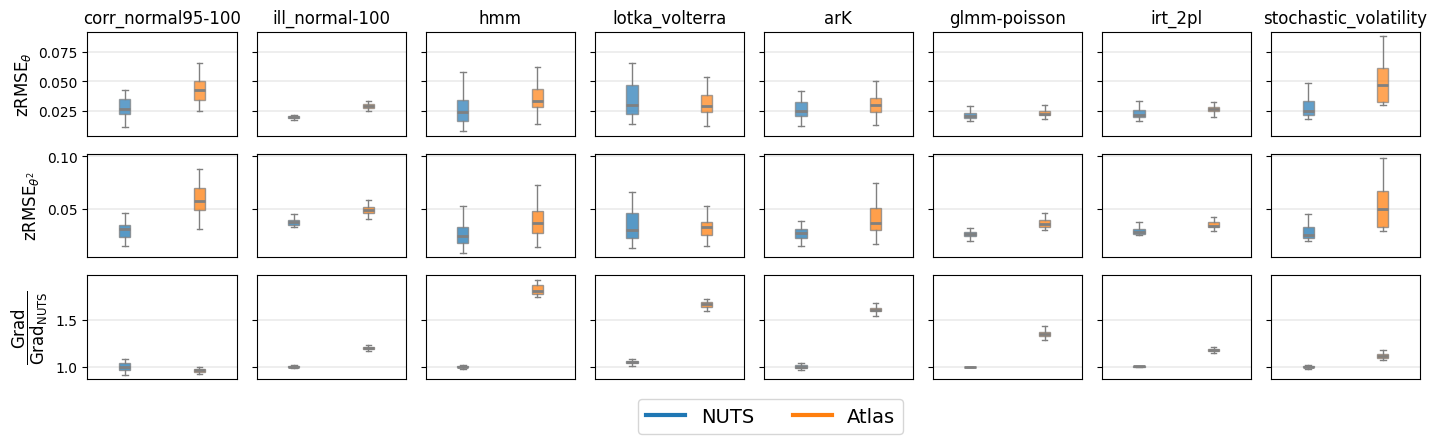

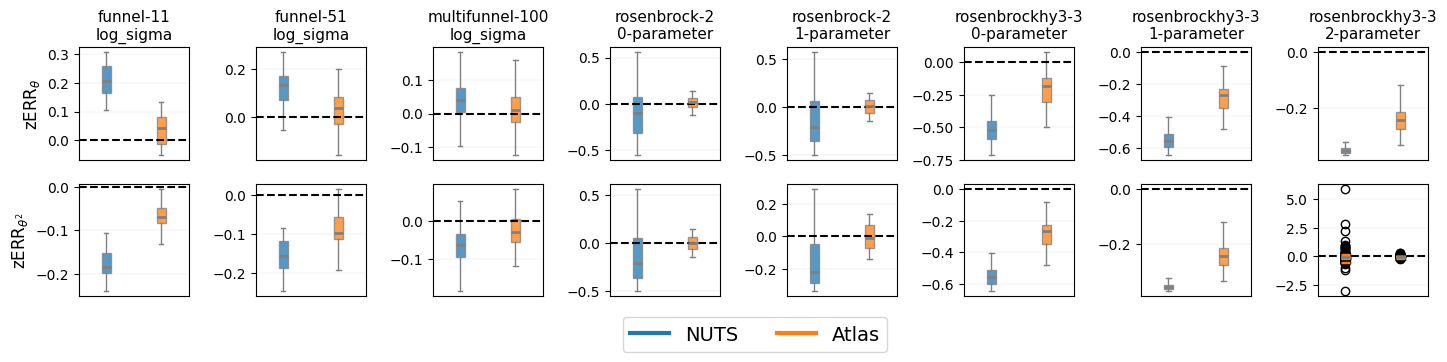

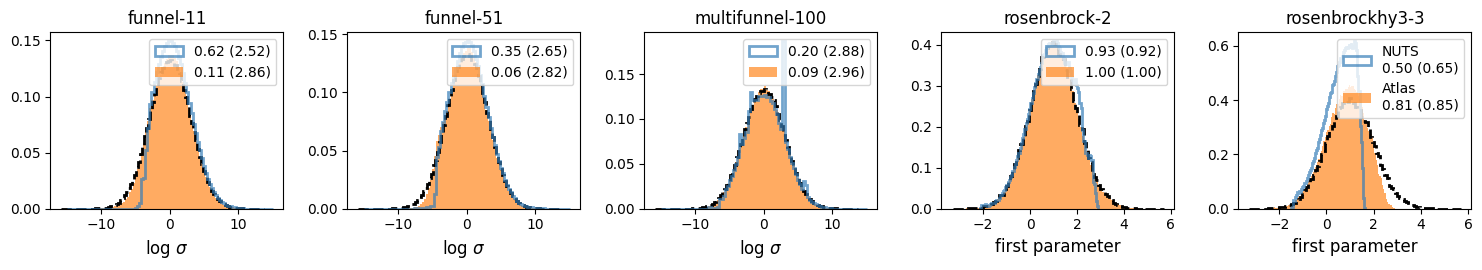

In [26]:
# keystoplot = ['nuts', 'atlas-logn', 'atlas-beta', 'atlas-logn-unif', 'atlas-beta-unif']
# keystoplot = ['nuts', 'atlas-logn',  'atlas-logn-unif']

save = False
save = False
prefix = 'atlas_nuts'

# keystoplot = ['nuts', 'atlas-logn-unif',  'atlas-logn-unif-0.6']#, 'atlas-logn-unif-0.65']
# labels = ['NUTS', 'Atlas (nuts)',  'Atlas (0.6)']#,  'Atlas (0.65)']

keystoplot = ['nuts', 'atlas-logn-unif']#, 'atlas-logn-unif-0.65']
labels = ['NUTS', 'Atlas']#,  'Atlas (0.65)']
boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
plt.show()

boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, fliers=False, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_funbrock.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_funbrock.pdf', bbox_inches='tight')
plt.show()

histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_hist.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_hist.pdf', bbox_inches='tight')
plt.show()



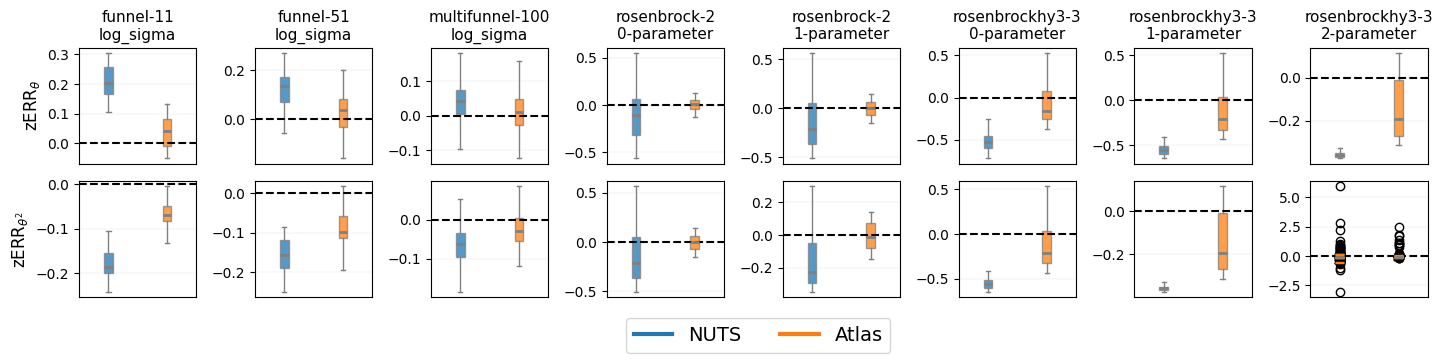

In [21]:
_, _, boxplots = boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, fliers=False, lbls=labels)



In [22]:
boxplots['funnel-11'][0]

{'whiskers': [<matplotlib.lines.Line2D at 0x155491ccad40>,
 'caps': [<matplotlib.lines.Line2D at 0x155491ccb670>,
 'boxes': [<matplotlib.lines.Line2D at 0x155491cca410>,
 'medians': [<matplotlib.lines.Line2D at 0x155491cc9300>,
 'fliers': [<matplotlib.lines.Line2D at 0x155491ccb1c0>,
 'means': []}

In [23]:
for item in boxplots['funnel-11'][0]['medians']:
    print(item.get_ydata())
print()
for item in boxplots['funnel-11'][0]['whiskers']:
    print(item.get_ydata())
print()
for item in boxplots['funnel-11'][0]['boxes']:
    print(item.get_ydata())


[0.20422878 0.20422878]
[0.04210272 0.04210272]

[0.16472349 0.1062287 ]
[0.25779758 0.30510238]
[-0.01124528 -0.05099409]
[0.08046315 0.13268541]

[0.16472349 0.16472349 0.25779758 0.25779758 0.16472349]
[-0.01124528 -0.01124528  0.08046315  0.08046315 -0.01124528]


[0.26400106 0.26400106 0.75478842 0.75478842 0.26400106]
0.507505017621154 0.26400106386085265 0.7547884152268488


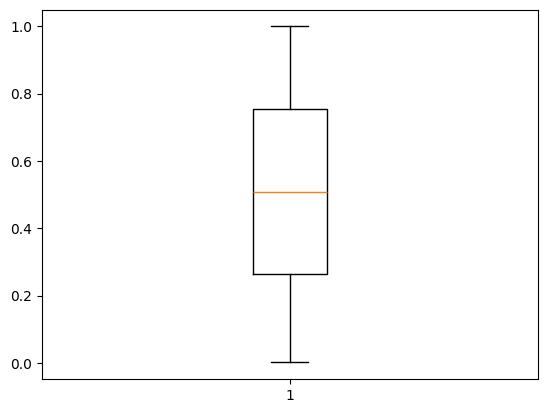

In [24]:
tmp = np.random.random(1000)
print(plt.boxplot(tmp)['boxes'][0].get_ydata())

print(np.median(tmp), np.percentile(tmp, 25), np.percentile(tmp, 75))

## ESS

In [24]:
import arviz as az

In [25]:
# exp = 'lotka_volterra'
# exp = 'stochastic_volatility'
exp = 'irt_2pl'
i = 0 
s_atlas = alldata[exp]['atlas-logn-unif'][-1]
g_atlas = alldata[exp]['atlas-logn-unif'][0]
# s_atlas = alldata[exp]['atlas-logn-unif-0.6'][-1]
# g_atlas = alldata[exp]['atlas-logn-unif-0.6'][0]
s_nuts = alldata[exp]['nuts'][-1]
g_nuts = alldata[exp]['nuts'][0]
print('D=', s_nuts.shape[-1])
az.rhat(s_atlas[..., i]), az.rhat(s_nuts[..., i])

D= 143


(1.0015113726048892, 1.0005421399087038)

In [26]:
az.ess(alldata[exp]['atlas-logn-unif'][-1][..., i]), az.ess(alldata[exp]['nuts'][-1][..., i])

(79202.24966869364, 112324.66273950977)

In [27]:
# np.sum([az.ess(alldata[exp]['atlas-logn-unif'][-1][j, :, i]) for j in range(32)])

In [28]:
ess_atlas, ess_nuts = [az.ess(s_atlas[:, :, i]) for i in range(s_atlas.shape[-1])], [az.ess(s_nuts[:, :, i]) for i in range(s_atlas.shape[-1])]
ess_atlas2, ess_nuts2 = [az.ess(s_atlas[:, :, i]**2) for i in range(s_atlas.shape[-1])], [az.ess(s_nuts[:, :, i]**2) for i in range(s_atlas.shape[-1])]


In [29]:
ess_atlas, ess_nuts = [az.ess(s_atlas[:, :, i]) for i in range(s_atlas.shape[-1])], [az.ess(s_nuts[:, :, i]) for i in range(s_atlas.shape[-1])]
# ess_atlas, ess_nuts = [az.ess(s_atlas[:, :, i]**2) for i in range(s_atlas.shape[-1])], [az.ess(s_nuts[:, :, i]**2) for i in range(s_atlas.shape[-1])]
imin_atlas, imin_nuts = np.argmin(ess_atlas), np.argmin(ess_nuts)
print(imin_atlas, imin_nuts)
print(ess_atlas[imin_atlas], ess_nuts[imin_nuts])

100 100
9291.567967922396 13240.09415432592


In [214]:
# plt.plot(az.autocorr(s_atlas[..., 0])[:, :10].T, 'C0');
# plt.plot(az.autocorr(s_atlas[..., 0]**2)[:, :10].T, 'C1');

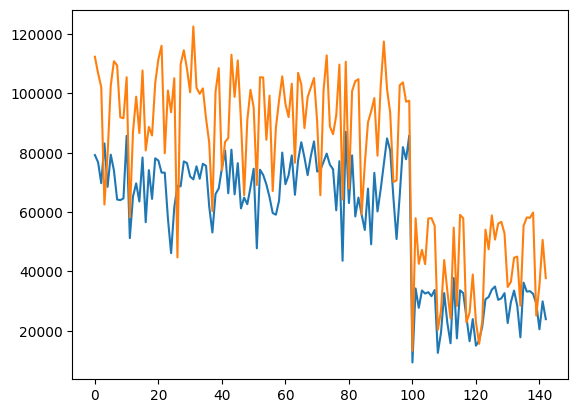

In [215]:
plt.plot(ess_atlas)
plt.plot(ess_nuts)


In [216]:
# az.ess(s_atlas[:, :, imin_atlas]), sum([az.ess(s_atlas[j, :, imin_atlas])  for j in range(32)]), az.ess(s_nuts[:, :, imin_atlas]), sum([az.ess(s_nuts[j, :, imin_atlas])  for j in range(32)])

In [217]:
print(g_atlas.sum()/ess_atlas[imin_atlas], g_nuts.sum()/ess_nuts[imin_atlas])
print((g_atlas.sum()/ess_atlas[imin_atlas])/(g_nuts.sum()/ess_nuts[imin_atlas]))

507.49486160777377 302.2758715573317
1.6789129049339913


In [218]:
print(g_atlas.sum()/ess_atlas[imin_nuts], g_nuts.sum()/ess_nuts[imin_nuts])
print((g_atlas.sum()/ess_atlas[imin_nuts])/(g_nuts.sum()/ess_nuts[imin_nuts]))

507.49486160777377 302.2758715573317
1.6789129049339913


In [219]:
print(ess_atlas[imin_nuts]/ess_nuts[imin_nuts])


0.7017750674293033


In [186]:
# az.ess(alldata[exp]['atlas-logn-unif'][-1][..., i])/alldata[exp]['atlas-logn-unif'][0].sum(), az.ess(alldata[exp]['nuts'][-1][..., i])/alldata[exp]['nuts'][0].sum()


In [53]:
for exp in alldata:
    print(exp, '\t', "%0.3f"%(alldata[exp]['atlas-logn-unif'][0].mean()/alldata[exp]['nuts'][0].mean()), '\t', "%0.3f"%(alldata[exp]['nuts0.95'][0].mean()/alldata[exp]['nuts'][0].mean() ))
# for exp in alldata:
#     print("%0.3f"%(alldata[exp]['atlas-logn-unif-0.6'][0].mean()/alldata[exp]['nuts'][0].mean()))

rosenbrock-2 	 4.849 	 4.785
funnel-11 	 8.113 	 0.640
funnel-51 	 1.824 	 0.637
multifunnel-100 	 2.335 	 1.826
rosenbrockhy3-3 	 17.490 	 8.398
corr_normal95-100 	 0.962 	 1.447
ill_normal-100 	 1.203 	 1.315
hmm 	 1.821 	 1.501
lotka_volterra 	 1.756 	 1.524
arK 	 1.611 	 1.651
glmm-poisson 	 1.352 	 1.396
irt_2pl 	 1.178 	 1.376
stochastic_volatility 	 1.112 	 1.696


In [22]:
# plt.plot((alldata['rosenbrock-2']['nuts'][-1][..., 0].cumsum(axis=1)/np.arange(1, 50000, 1)).mean(axis=0))
# plt.plot((alldata['rosenbrock-2']['atlas-logn-unif'][-1][..., 0].cumsum(axis=1)/np.arange(1, 50000, 1)).mean(axis=0))
# plt.loglog()
# plt.axhline(1, color='k')
# # plt.yscale('log')

In [23]:
# plt.plot(((alldata['funnel-11']['nuts'][-1][..., 0]**2).cumsum(axis=1)/np.arange(1, 50000, 1)).mean(axis=0))
# plt.plot(((alldata['funnel-11']['atlas-logn-unif'][-1][..., 0]**2).cumsum(axis=1)/np.arange(1, 50000, 1)).mean(axis=0))
# plt.loglog()
# plt.axhline(9, color='k')
# # plt.yscale('log')

# Only stepsize adaptation - non-DR

In [24]:
# for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']

    suffixes = [  '-uninleap-lognormal-stepsig1.2']
    keys = [ 'sadapt-logn-unif']
    # suffixes = [ '', '-lognormal-stepsig1.2']
    # keys = ['sadapt-beta', 'sadapt-logn']
    # suffixes += ['-uninleap']
    # keys += ['sadapt-beta-unif', 'sadapt-logn-unif']
    algfolder = 'nodr_stepadapt-indep' 
    ik = 0
    for suffix in suffixes: 
        for offset in [1.0]:
            key = f"{keys[ik]}"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target0.80{suffix}/'
            if check_key(key, exp, nsamples, nchains):
                data = get_data(path, key, data, nsamples)

    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
sadapt-logn-unif for rosenbrock-2 not found. Rerun
funnel-11
sadapt-logn-unif for funnel-11 not found. Rerun
funnel-51
sadapt-logn-unif for funnel-51 not found. Rerun
multifunnel-100
sadapt-logn-unif for multifunnel-100 not found. Rerun
rosenbrockhy3-3
sadapt-logn-unif for rosenbrockhy3-3 not found. Rerun
corr_normal95-100
sadapt-logn-unif for corr_normal95-100 not found. Rerun
ill_normal-100
sadapt-logn-unif for ill_normal-100 not found. Rerun
hmm
sadapt-logn-unif for hmm not found. Rerun
lotka_volterra
sadapt-logn-unif for lotka_volterra not found. Rerun
arK
sadapt-logn-unif for arK not found. Rerun
glmm-poisson
sadapt-logn-unif for glmm-poisson not found. Rerun
irt_2pl
sadapt-logn-unif for irt_2pl not found. Rerun
stochastic_volatility
sadapt-logn-unif for stochastic_volatility not found. Rerun


In [25]:
# keystoplot = ['nuts', 'atlas-logn-unif', 'sadapt-logn', 'sadapt-logn-unif']
# # keystoplot = ['nuts','sadapt-logn-unif',  'sadapt-beta-unif']
# boxplot_experiments(alldata, sharex='col', sharey=False, baselines=None, keystoplot=keystoplot)
# plt.show()
# boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot)
# plt.show()
# histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot)
# plt.show()

# Only stepsize adaptation - DR

In [25]:
# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']

    suffixes = ['-uninleap-lognormal-stepsig1.2']
    keys = ['sadapt-DR-logn-unif']
    # suffixes += [  '-lognormal-stepsig1.2'] 
    # keys += [ 'sadapt-DR-logn']

    # suffixes = [ '', '-lognormal-stepsig1.2'] 
    # keys = ['sadapt-DR-beta', 'sadapt-DR-logn']
    # suffixes += ['-uninleap', '-uninleap-lognormal-stepsig1.2']
    # keys += ['sadapt-DR-beta-unif', 'sadapt-DR-logn-unif',  'sadapt-logn-s2-unif']
    
    algfolder = 'dr_stepadapt-indep' 
    ik = 0
    for suffix in suffixes: 
        for offset in [1.0]:
            key = f"{keys[ik]}"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target0.80{suffix}/'
            if check_key(key, exp, nsamples, nchains):
                data = get_data(path, key, data, nsamples)
                  
    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
sadapt-DR-logn-unif for rosenbrock-2 not found. Rerun
funnel-11
sadapt-DR-logn-unif for funnel-11 not found. Rerun
funnel-51
sadapt-DR-logn-unif for funnel-51 not found. Rerun
multifunnel-100
sadapt-DR-logn-unif for multifunnel-100 not found. Rerun
rosenbrockhy3-3
sadapt-DR-logn-unif for rosenbrockhy3-3 not found. Rerun
corr_normal95-100
sadapt-DR-logn-unif for corr_normal95-100 not found. Rerun
ill_normal-100
sadapt-DR-logn-unif for ill_normal-100 not found. Rerun
hmm
sadapt-DR-logn-unif for hmm not found. Rerun
lotka_volterra
sadapt-DR-logn-unif for lotka_volterra not found. Rerun
arK
sadapt-DR-logn-unif for arK not found. Rerun
glmm-poisson
sadapt-DR-logn-unif for glmm-poisson not found. Rerun
irt_2pl
sadapt-DR-logn-unif for irt_2pl not found. Rerun
stochastic_volatility
sadapt-DR-logn-unif for stochastic_volatility not found. Rerun


In [26]:

# keystoplot = ['nuts',  'sadapt-logn-unif',  'sadapt-DR-logn-unif',  'sadapt-beta-unif',  'sadapt-DR-beta-unif']
# boxplot_experiments(alldata, sharex='col', sharey=False, baselines=None, keystoplot=keystoplot)
# plt.show()

# boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot)
# plt.show()

# histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot)
# plt.show()

### plot

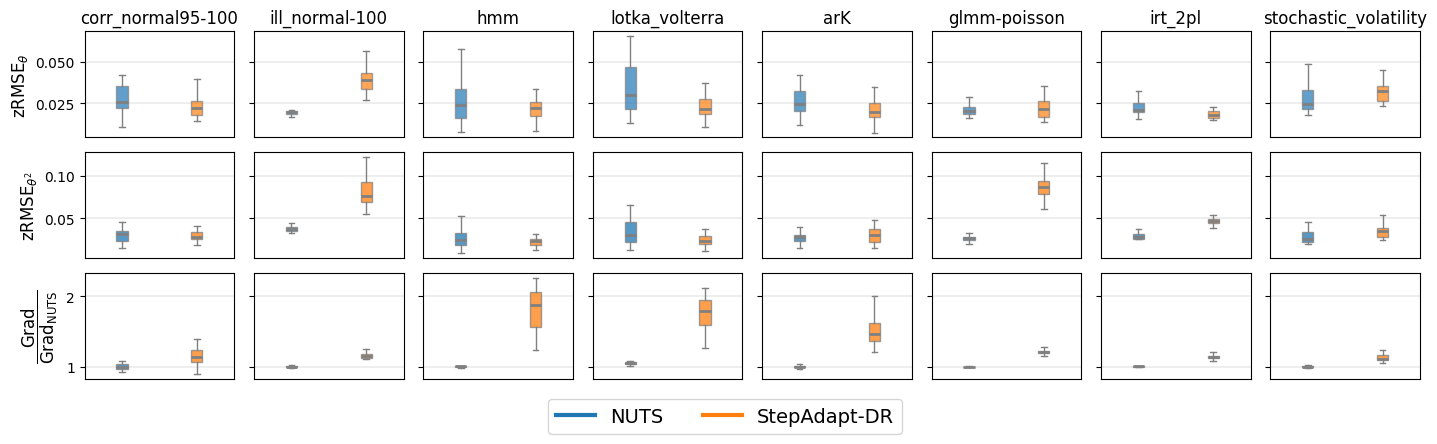

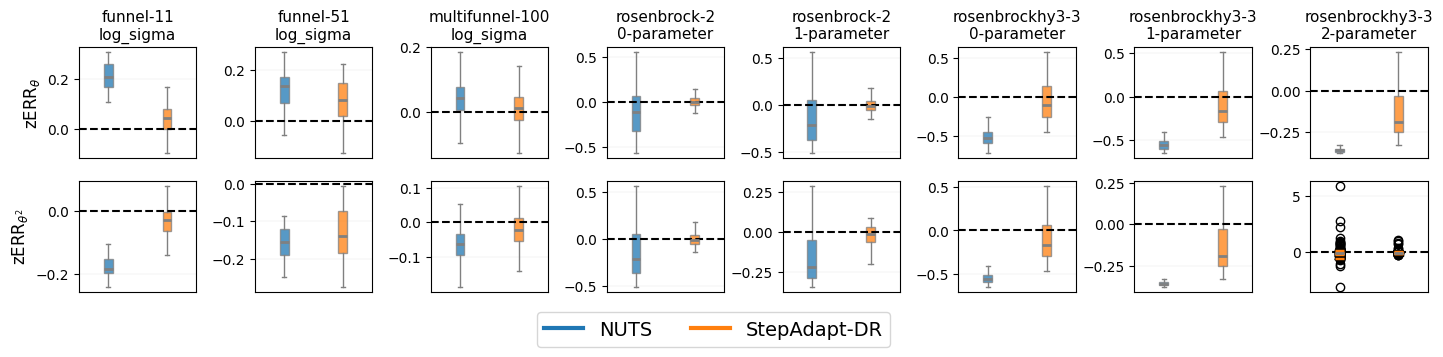

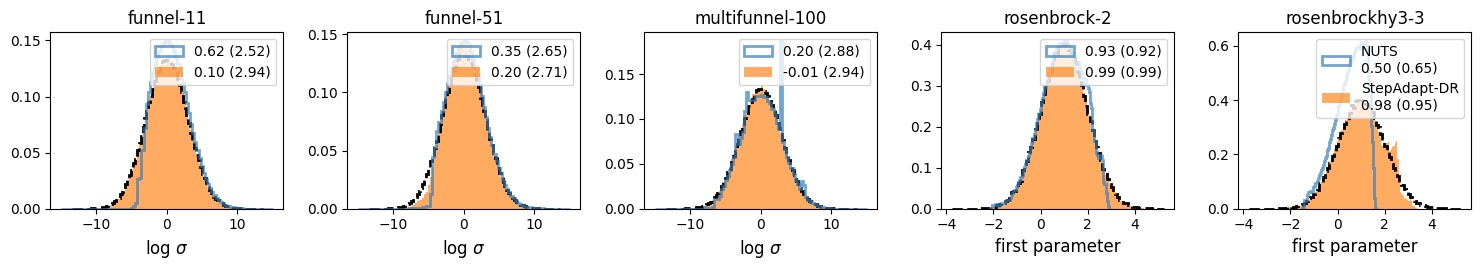

In [27]:
# save = True
save = False
prefix = 'stepadapt'

# keystoplot = ['nuts',  'sadapt-logn-unif', 'sadapt-DR-logn-unif']#, 'atlas-logn-unif']
# lbls = ['NUTS', 'StepAdapt', 'StepAdapt-DR']#, 'Atlas']
keystoplot = ['nuts', 'sadapt-DR-logn-unif']#, 'atlas-logn-unif']
lbls = ['NUTS', 'StepAdapt-DR']#, 'Atlas']
boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=lbls)
if save : 
    plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
plt.show()

boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, lbls=lbls)
if save : 
    plt.savefig(f'./figs/{prefix}_funbrock.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_funbrock.pdf', bbox_inches='tight')
plt.show()

histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=lbls)
if save : 
    plt.savefig(f'./figs/{prefix}_hist.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_hist.pdf', bbox_inches='tight')
plt.show()


# Atlas HMC (vanilla traj and step adaptation)

In [20]:
# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']
    
    # suffixes = [ '', '-lognormal-stepsig1.2']
    # keys = ['atlas-hmc-beta', 'atlas-hmc-logn']
    suffixes = [ '-lognormal-stepsig1.2']
    keys = [ 'atlas-hmc-logn']
    algfolder = 'atlas-hmc' 
    ik = 0
    for suffix in suffixes: 
        key = f"{keys[ik]}"
        ik += 1
        path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00{suffix}/'
        if check_key(key, exp, nsamples, nchains):
            if exp == 'multifunnel-100' :
                samples = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(16)])[:, :nsamples].astype('float32')
                grads = np.stack([np.load(f'{path}/gradcounts-{i}.npy')[:nsamples] for i in range(16)])[:, :nsamples].astype('float32')
                count = grads[:, :nsamples].sum(axis=1)
                rmses, errs = get_rmses(samples, data['ref'])
                data[key] =  count, rmses, errs, samples

            else: data = get_data(path, key, data, nsamples)
            
    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
atlas-hmc-logn for rosenbrock-2 not found. Rerun
funnel-11
atlas-hmc-logn for funnel-11 not found. Rerun
funnel-51
atlas-hmc-logn for funnel-51 not found. Rerun
multifunnel-100
atlas-hmc-logn for multifunnel-100 not found. Rerun
rosenbrockhy3-3
atlas-hmc-logn for rosenbrockhy3-3 not found. Rerun
corr_normal95-100
atlas-hmc-logn for corr_normal95-100 not found. Rerun
ill_normal-100
atlas-hmc-logn for ill_normal-100 not found. Rerun
hmm
atlas-hmc-logn for hmm not found. Rerun
lotka_volterra
atlas-hmc-logn for lotka_volterra not found. Rerun
arK
atlas-hmc-logn for arK not found. Rerun
glmm-poisson
atlas-hmc-logn for glmm-poisson not found. Rerun
irt_2pl
atlas-hmc-logn for irt_2pl not found. Rerun
stochastic_volatility
atlas-hmc-logn for stochastic_volatility not found. Rerun


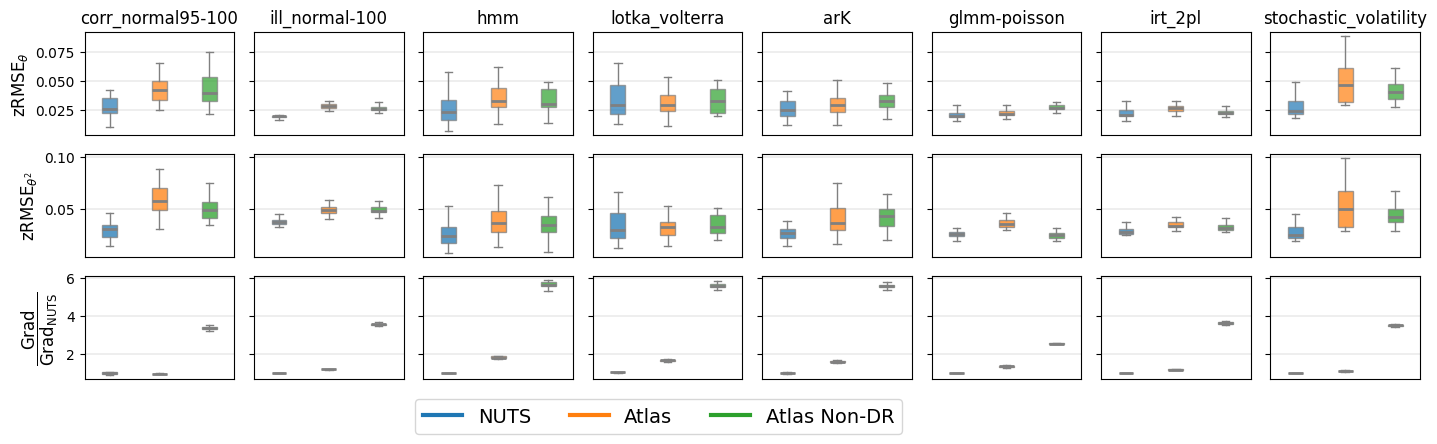

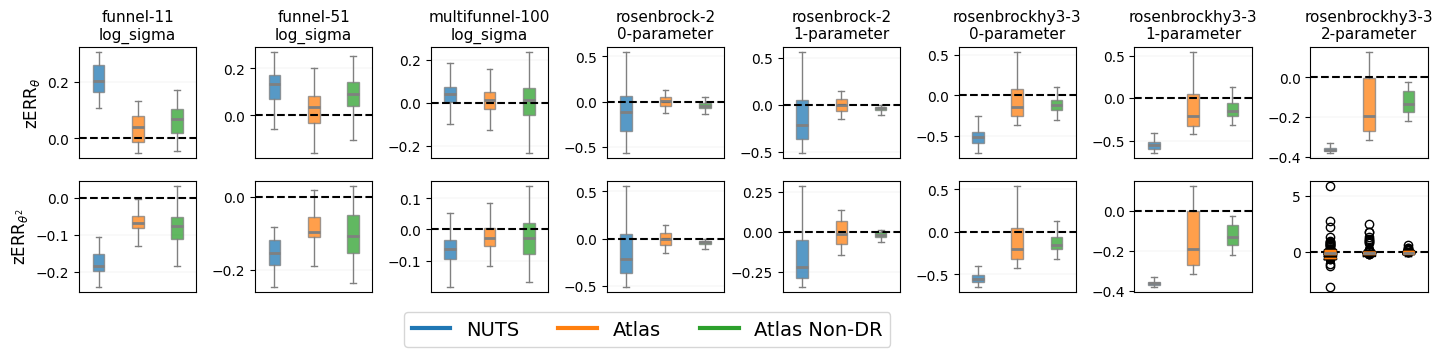

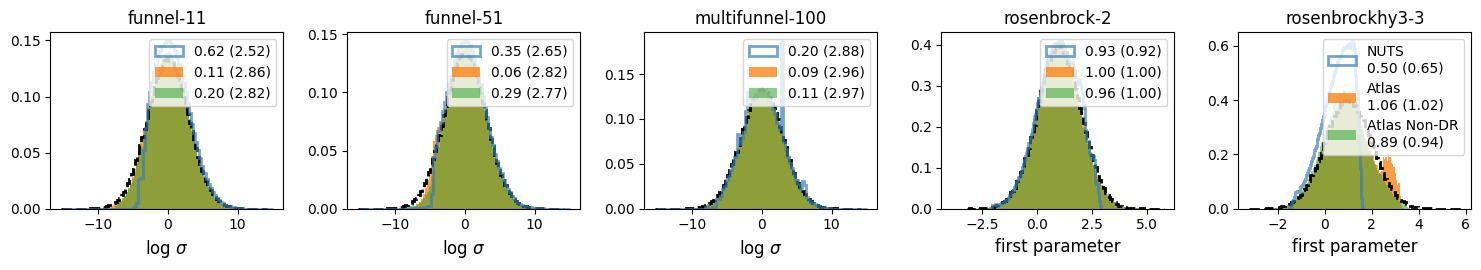

In [22]:
# save = True
save = False
prefix = 'atlas_hmc'

keystoplot = ['nuts',   'atlas-logn-unif', 'atlas-hmc-logn']
labels = ['NUTS', 'Atlas', 'Atlas Non-DR']
# keystoplot = ['nuts',  'atlas-hmc-logn',  'atlas-logn-unif']
# labels = ['NUTS', 'Atlas-simple', 'Atlas-DR(NUTS)']
# keystoplot = ['nuts',  'atlas-hmc-logn']
# labels = ['NUTS', 'Atlas-simple']
boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
plt.show()

boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_funbrock.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_funbrock.pdf', bbox_inches='tight')
plt.show()

histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_hist.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_hist.pdf', bbox_inches='tight')
plt.show()


### motivate trajectory length adaptation

In [30]:
gnuts = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.80/leapfrogs.npy')
logsigma = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.80/samples.npy')[..., 0]

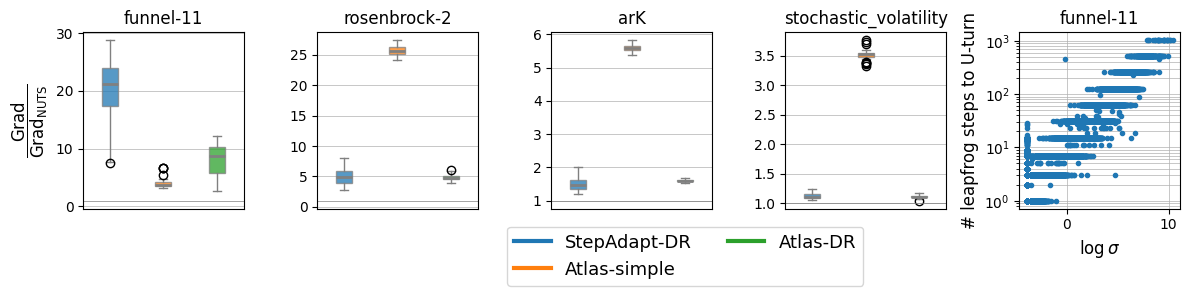

In [31]:
fig, ax = plt.subplots(1, 5, figsize=(12, 2.8))
bplots = []

labels = ['StepAdapt-DR', 'Atlas-simple', 'Atlas-DR']
exp = 'funnel-11'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[0].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm, alldata[exp]['atlas-hmc-logn'][0]/norm, alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75), medianprops={"linewidth":0, "linestyle":None}, meanline=False))
ax[0].set_title('funnel-11')
ax[0].set_ylabel(r'$\mathrm{\dfrac{Grad}{Grad_{NUTS}}}$', fontsize=12)

exp = 'rosenbrock-2'
# exp = 'glmm-poisson'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[1].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm, alldata[exp]['atlas-hmc-logn'][0]/norm, alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
ax[1].set_title(exp)

# exp = 'corr_normal95-100'
# # exp = 'glmm-poisson'
# norm = alldata[exp]['nuts'][0].mean()
# bplots.append(ax[2].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm, alldata[exp]['atlas-hmc-logn'][0]/norm, alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
#                             patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
# ax[2].set_title(exp)

exp = 'arK'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[2].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm, alldata[exp]['atlas-hmc-logn'][0]/norm, alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
ax[2].set_title(exp)

exp = 'stochastic_volatility'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[-2].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm, alldata[exp]['atlas-hmc-logn'][0]/norm, alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels,
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
ax[-2].set_title(exp)

set_boxplot_colors(bplots)

# ax[2].plot(logsigma.flatten()[::10], gnuts.flatten()[::10], '.')
ax[-1].plot(logsigma[0], gnuts[0], '.')
ax[-1].semilogy()
ax[-1].set_xlabel('$\log \sigma$', fontsize=12)
ax[-1].set_ylabel('# leapfrog steps to U-turn', fontsize=12)
ax[-1].set_title('funnel-11')
for axis in ax[:-1]:
    # axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=15)#, ha='right')
    axis.set_xticks([])#, ha='right')
    axis.axhline(1, color='gray', lw=0.5)

for axis in ax:
    axis.grid(which='both', lw=0.5)
plt.tight_layout()

for i in range(len(labels)):
    ax[2].plot(np.NaN, np.NaN, color=f'C{i}', label=labels[i], lw=3)
ax[2].legend(bbox_to_anchor=(1, -0.05, 1, 0), ncol=len(lbls), fontsize=13)

# plt.savefig('./figs/compare_costs.png')
# plt.savefig('./figs/compare_costs.pdf')

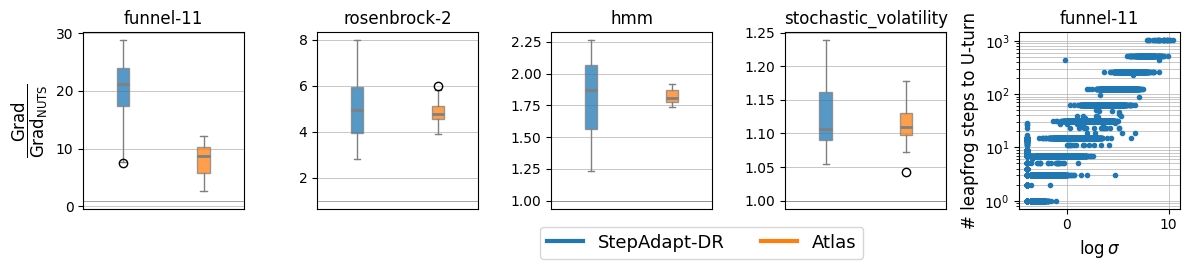

In [32]:
fig, ax = plt.subplots(1, 5, figsize=(12, 2.8))
bplots = []

labels = ['StepAdapt-DR',  'Atlas']
exp = 'funnel-11'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[0].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm,  alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75), medianprops={"linewidth":0, "linestyle":None}, meanline=False))
ax[0].set_title('funnel-11')
ax[0].set_ylabel(r'$\mathrm{\dfrac{Grad}{Grad_{NUTS}}}$', fontsize=12)

exp = 'rosenbrock-2'
# exp = 'glmm-poisson'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[1].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm,  alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
ax[1].set_title(exp)


exp = 'hmm'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[2].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm,  alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels, 
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
ax[2].set_title(exp)

exp = 'stochastic_volatility'
norm = alldata[exp]['nuts'][0].mean()
bplots.append(ax[-2].boxplot([alldata[exp]['sadapt-DR-logn-unif'][0]/norm, alldata[exp]['atlas-logn-unif'][0]/norm], labels=labels,
                            patch_artist=True, boxprops=dict(facecolor='C0', color='C0', alpha=0.75)))
ax[-2].set_title(exp)

set_boxplot_colors(bplots)

# ax[2].plot(logsigma.flatten()[::10], gnuts.flatten()[::10], '.')
ax[-1].plot(logsigma[0], gnuts[0], '.')
ax[-1].semilogy()
ax[-1].set_xlabel('$\log \sigma$', fontsize=12)
ax[-1].set_ylabel('# leapfrog steps to U-turn', fontsize=12)
ax[-1].set_title('funnel-11')
for axis in ax[:-1]:
    # axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=15)#, ha='right')
    axis.set_xticks([])#, ha='right')
    axis.axhline(1, color='gray', lw=0.5)

for axis in ax:
    axis.grid(which='both', lw=0.5)
plt.tight_layout()

for i in range(len(labels)):
    ax[2].plot(np.NaN, np.NaN, color=f'C{i}', label=labels[i], lw=3)
ax[2].legend(bbox_to_anchor=(1, -0.05, 1, 0), ncol=len(lbls), fontsize=13)

# plt.savefig('./figs/compare_costs.png')
# plt.savefig('./figs/compare_costs.pdf')

# Sensitivity to initial stepsize

In [25]:
for dist, suffix in list(zip(['beta', 'logn'], ['', '-lognormal-stepsig1.2'])):
    print(dist, suffix)

beta 
logn -lognormal-stepsig1.2


In [18]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100",   "ill_normal-100", "hmm", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
        
    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']

        
    ta = 0.8
    # for sfac in [1.10, 1.25]:
    for sfac in [1.10, 1.2]:
        key = f'nuts-s{sfac:0.2f}x'
        try:            
            if check_key(key, exp, nsamples, nchains):
                nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}-stepfac{sfac}/'
                snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
                gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
                count = gnuts.sum(axis=-1)
                rmses, errs = get_rmses(snuts, data['ref'])
                data[key] = [count, rmses, errs, snuts]
        except:
            PrintException()
        

    # algfolder = 'atlasv2-nuts-indep' 
    algfolder = 'atlasv2prop-nuts-indep' 
    offset = 1.0

    # for dist, suffix in list(zip(['beta', 'logn'], ['', '-lognormal-stepsig1.2'])):
    #     for sfac in [1., 1.25,  1.5]:#, 2.0]:        
    #         if sfac == 1.:
    #             key = f'atlas-{dist}'
    #             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2{suffix}/'
    #         else:
    #             key = f'atlas-{dist}-s{sfac:0.2f}x'
    #             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2{suffix}-stepfac{sfac}/'
    #         if check_key(key, exp, nsamples, nchains):
    #             data = get_data(path, key, data, nsamples)


    # for dist, suffix in list(zip(['beta', 'logn'], ['', '-lognormal-stepsig1.2'])):
    for dist, suffix in list(zip(['logn'], ['-lognormal-stepsig1.2'])):
        # for sfac in [1., 1.10, 1.20, 1.5, 2.]:        
        for sfac in [1., 1.10, 1.20]:        
            if sfac == 1.:
                key = f'atlas-{dist}-unif'
                path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2-uninleap{suffix}/'
            else:
                key = f'atlas-{dist}-unif-s{sfac:0.2f}x'
                path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2-uninleap{suffix}-stepfac{sfac}/'
            if check_key(key, exp, nsamples, nchains):
                data = get_data(path, key, data, nsamples)


#     for sfac in [1., 1.25,  1.5, 2.0]:
        
#         if sfac == 1.:
#             key = f'atlas-logn-25-75'
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2-lognormal-stepsig1.2-lownl25-highnl75/'
#         else:
#             key = f'atlas-logn-25-75-s{sfac:0.2f}x'
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-lownl25-highnl75/'
#         if check_key(key, exp, nsamples, nchains):
#             data = get_data(path, key, data, nsamples)

            
#     for sfac in [1., 1.25,  1.5, 2.0]:
        
#         if sfac == 1.:
#             key = f'atlas-logn-25-75-unif'
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2-uninleap-lognormal-stepsig1.2-lownl25-highnl75/'
#         else:
#             key = f'atlas-logn-25-75-unif-s{sfac:0.2f}x'
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-lownl25-highnl75/'
#         if check_key(key, exp, nsamples, nchains):
#             data = get_data(path, key, data, nsamples)
            
            
    for key in data:
        alldata[exp][key] = data[key]
    

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
nuts-s1.10x for rosenbrock-2 not found. Rerun
nuts-s1.20x for rosenbrock-2 not found. Rerun
atlas-logn-unif for rosenbrock-2 not found. Rerun
atlas-logn-unif-s1.10x for rosenbrock-2 not found. Rerun
atlas-logn-unif-s1.20x for rosenbrock-2 not found. Rerun
EXCEPTION IN (/tmp/ipykernel_2696330/3832523890.py, LINE 27 "samples = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])[:, :nsamples].astype('float32')"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac1.2//samples_constrained-0.npy'
funnel-11
nuts-s1.10x for funnel-11 not found. Rerun
nuts-s1.20x for funnel-11 not found. Rerun
atlas-logn-unif for funnel-11 not found. Rerun
atlas-logn-unif-s1.10x for funnel-11 not found. Rerun
atlas-logn-unif-s1.20x for funnel-11 not found. Rerun
EXCEPTION IN (/tmp/ipykernel_2696330/3832523890.py, LINE 27 "samples = np.sta

### plot

In [21]:
alldata['hmm'].keys()

dict_keys(['ref', 'nuts', 'nuts0.95', 'nuts0.99', 'nuts-s1.10x', 'nuts-s1.20x', 'atlas-logn-unif', 'atlas-logn-unif-s1.10x', 'atlas-logn-unif-s1.20x'])

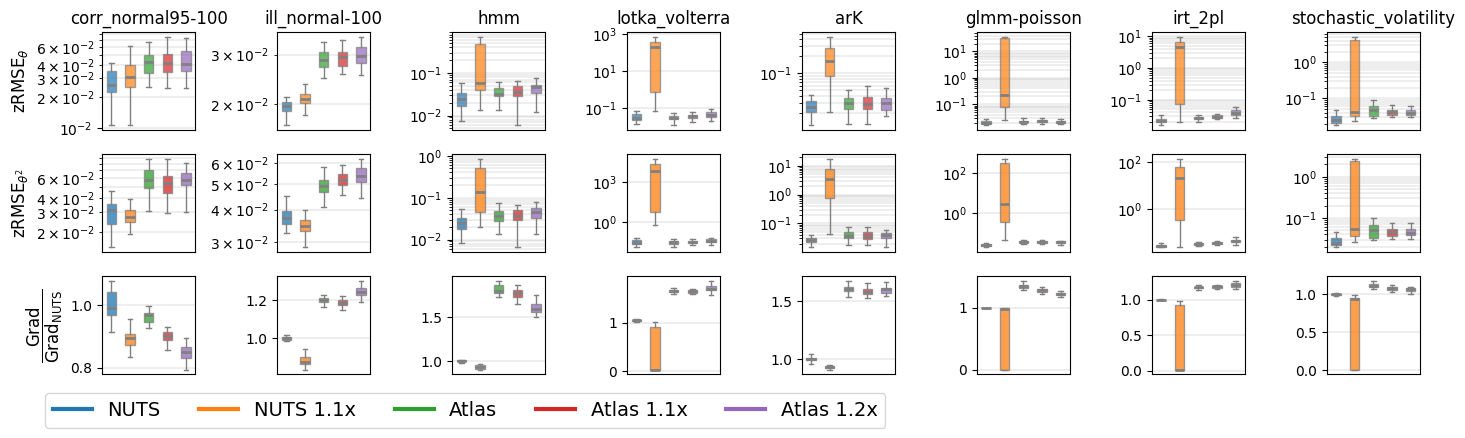

In [25]:
save = False
save = False
prefix = 'sensitivity'

# keystoplot = ['nuts', 'nuts-s1.25x', 'atlas-logn-unif', 'atlas-logn-unif-s1.25x']
# keystoplot = ['nuts',  'atlas-logn-unif', 'nuts-s1.10x', 'atlas-logn-unif-s1.10x', 'atlas-logn-unif-s1.50x', 'atlas-logn-unif-s2.00x']
keystoplot = ['nuts', 'nuts-s1.10x', 'atlas-logn-unif', 'atlas-logn-unif-s1.10x', 'atlas-logn-unif-s1.20x']
labels = ['NUTS',   'NUTS 1.1x', 'Atlas', 'Atlas 1.1x', 'Atlas 1.2x']
# keystoplot = ['nuts',  'atlas-logn-unif',  'atlas-logn-unif-s1.10x', 'atlas-logn-unif-s1.50x', 'atlas-logn-unif-s2.00x']
# labels = ['NUTS', 'Atlas',   'Atlas 1.1x', 'Atlas 1.5x', 'Atlas 2.0x']

boxplot_experiments(alldata, sharex='col', sharey=False, baselines=None, keystoplot=keystoplot, logscale=True, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
plt.show()

# boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, lbls=labels)
# if save : 
#     plt.savefig(f'./figs/{prefix}_funbrock.png', bbox_inches='tight')
#     plt.savefig(f'./figs/{prefix}_funbrock.pdf', bbox_inches='tight')
# plt.show()

# histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=labels)
# if save : 0
#     plt.savefig(f'./figs/{prefix}_hist.png', bbox_inches='tight')
#     plt.savefig(f'./figs/{prefix}_hist.pdf', bbox_inches='tight')
# plt.show()


In [ ]:
for exp in alldata:
    # print(exp, '\t', "%0.3f"%(alldata[exp]['atlas-logn-unif-s1.10x'][0].mean()/alldata[exp]['nuts'][0].mean()), '\t', "%0.3f"%(alldata[exp]['atlas-logn-unif'][0].mean()/alldata[exp]['nuts'][0].mean() ))
    print(exp, '\t', "%0.3f"%(alldata[exp]['atlas-logn-unif-s1.10x'][0].mean()/alldata[exp]['atlas-logn-unif'][0].mean()))


In [ ]:
# keystoplot = ['nuts', 'atlas-logn', 'atlas-logn-s1.25x', 'atlas-logn-s1.50x', 'atlas-logn-s2.00x',\
#                'atlas-logn-unif', 'atlas-logn-unif-s1.25x', 'atlas-logn-unif-s1.50x', 'atlas-logn-unif-s2.00x']
# # keystoplot = ['nuts', 'nuts-s1.25x', 'nuts-s1.50x',  'atlas-logn', 'atlas-logn-s1.25x', 'atlas-logn-s1.50x']
# boxplot_experiments(alldata, sharex='col', sharey=False, baselines=None, keystoplot=keystoplot, logscale=True)
# plt.show()

# boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot)
# plt.show()

# histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot)
# plt.show()

# Compare to old runs

In [49]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']

    # suffixes = [ '','-lognormal',  '-lognormal-stepsig1.2', '-uninleap','-uninleap-lognormal',  '-uninleap-lognormal-stepsig1.2']
    # suffixes = [ '-ctraj2-lognormal-stepsig1.2', '-ctraj2' , '-ctraj2-uninleap-lognormal-stepsig1.2', '-ctraj2-uninleap']
    # suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2', '-ctraj1-uninleap-lognormal-stepsig1.2']
    # keys = [ 'atlas-logn-unif-propold', 'atlas-logn-unif-ct1-propold']
    suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2']
    keys = [ 'atlas-logn-unif-propold']
    algfolder = 'atlasv2-nuts-indep' 
    ik = 0
    for suffix in suffixes: 
        for offset in [1.0]:
            key = f"{keys[ik]}"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00-prob1{suffix}/'
            if check_key(key, exp, nsamples, nchains):
                data = get_data(path, key, data, nsamples)
                
    # suffixes = [   '-ctraj1-uninleap-lognormal-stepsig1.2', '-ctraj2-uninleap-lognormal-stepsig1.2']
    # keys = [ 'atlas-logn-unif-ct1-p2-propold', 'atlas-logn-unif-ct2-p2-propold']
    # ik = 0 
    # for suffix in suffixes: 
    #     for offset in [1.0]:
    #         key = f"{keys[ik]}"
    #         ik += 1
    #         path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00-prob2{suffix}/'
    #         if check_key(key, exp, nsamples, nchains):
    #             data = get_data(path, key, data, nsamples)

#
#     suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2']
#     keys = [ 'atlas-logn-unif-combine']
#     algfolder = 'atlasv2-nuts' 
#     ik = 0
#     for suffix in suffixes: 
#         for offset in [1.0]:
#             key = f"{keys[ik]}"
#             ik += 1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00-prob1{suffix}/'
#             if check_key(key, exp, nsamples, nchains):
#                 data = get_data(path, key, data, nsamples)

    
    # prefixes = [   'target0.60',  'target0.65']#, 'target0.80']
    # suffixes = [   '-ctraj2-uninleap-lognormal-stepsig1.2' ]
    # keys = [ 'atlas-logn-unif-0.6', 'atlas-logn-unif-0.65']
    # algfolder = 'atlasv2-indep' 
    # ik = 0
    # for prefix in prefixes: 
    #     for suffix in suffixes: 
    #         for offset in [1.0]:
    #             key = f"{keys[ik]}"
    #             ik += 1
    #             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}/{algfolder}/{prefix}-offset1.00-prob1{suffix}/'
    #             if check_key(key, exp, nsamples, nchains):
    #                 data = get_data(path, key, data, nsamples)
    #         # target0.65-offset1.00-prob1-ctraj1-lognormal-stepsig1.2


    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

# /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-indep/target0.65-offset1.00-prob1-ctraj2-lognormal-stepsig1.2
# /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-indep/targe0.65-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/
# /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-indep/targe0.65-offset1.00-prob1-ctraj2-lognormal-stepsig1.2/

rosenbrock-2
atlas-logn-unif-propold for rosenbrock-2 not found. Rerun
funnel-11
atlas-logn-unif-propold for funnel-11 not found. Rerun
funnel-51
atlas-logn-unif-propold for funnel-51 not found. Rerun
multifunnel-100
atlas-logn-unif-propold for multifunnel-100 not found. Rerun
rosenbrockhy3-3
atlas-logn-unif-propold for rosenbrockhy3-3 not found. Rerun
corr_normal95-100
atlas-logn-unif-propold for corr_normal95-100 not found. Rerun
ill_normal-100
atlas-logn-unif-propold for ill_normal-100 not found. Rerun
hmm
atlas-logn-unif-propold for hmm not found. Rerun
lotka_volterra
atlas-logn-unif-propold for lotka_volterra not found. Rerun
arK
atlas-logn-unif-propold for arK not found. Rerun
glmm-poisson
atlas-logn-unif-propold for glmm-poisson not found. Rerun
irt_2pl
atlas-logn-unif-propold for irt_2pl not found. Rerun
stochastic_volatility
atlas-logn-unif-propold for stochastic_volatility not found. Rerun


## plot

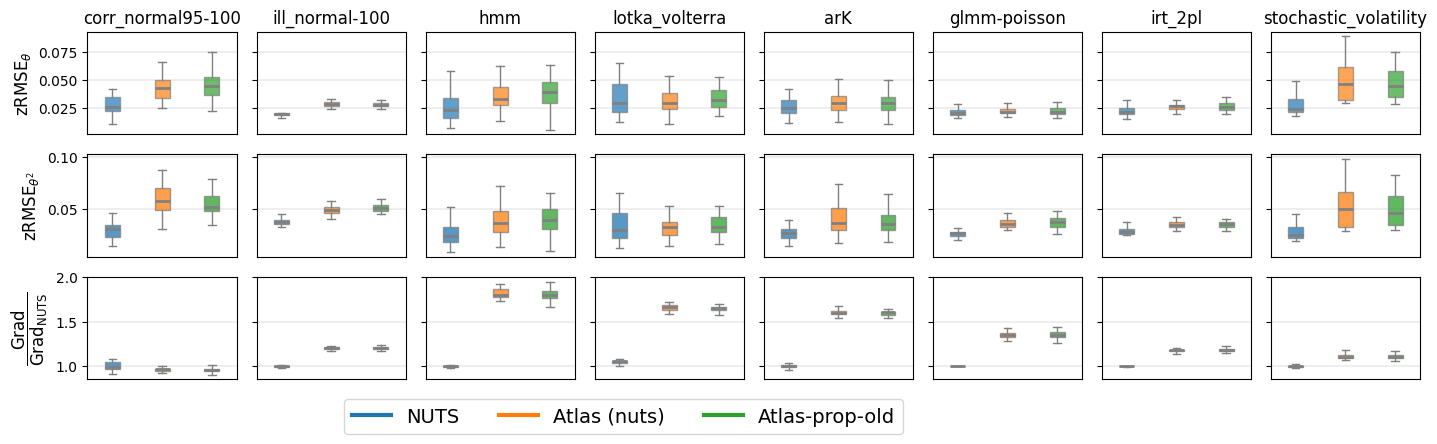

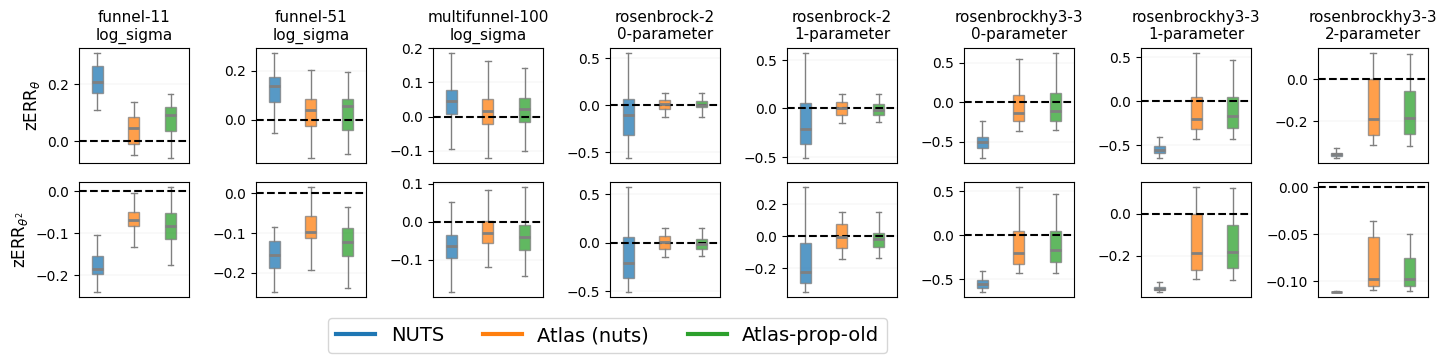

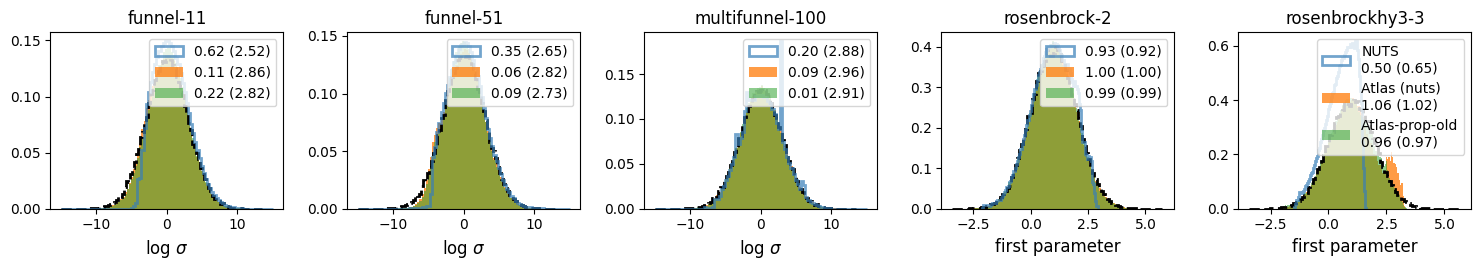

In [50]:
# keystoplot = ['nuts', 'atlas-logn', 'atlas-beta', 'atlas-logn-unif', 'atlas-beta-unif']
# keystoplot = ['nuts', 'atlas-logn',  'atlas-logn-unif']

save = True
save = False
prefix = 'atlas_nuts'

# keystoplot = ['nuts', 'prop-atlas-logn-unif', 'prop-atlas-logn-unif-p2']
# labels = ['NUTS',  'Atlas-prop', 'Atlas-prop-p2'] 
keystoplot = ['nuts', 'atlas-logn-unif',  'atlas-logn-unif-propold']
labels = ['NUTS', 'Atlas (nuts)',   'Atlas-prop-old'] 
# keystoplot = ['nuts', 'atlas-logn-unif',  'prop-atlas-logn-unif', 'prop-atlas-logn-unif-ct1', 'prop-atlas-logn-unif-ct2-p2', 'prop-atlas-logn-unif-ct1-p2']
# labels = ['NUTS', 'Atlas (nuts)',   'Atlas-prop',   'Atlas-prop-ct1',  'Atlas-prop-p2',  'Atlas-prop-ct1-p2'] 
# keystoplot = ['nuts', 'atlas-logn-unif',  'atlas-logn-unif-0.6', 'prop-atlas-logn-unif']#, 'atlas-logn-unif-0.65']
# labels = ['NUTS', 'Atlas (nuts)',  'Atlas (0.6)', 'Atlas-prop'] #,  'Atlas (0.65)']
boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
plt.show()

boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, fliers=False, lbls=labels)
if save : 
    plt.savefig(f'./figs/{prefix}_funbrock.png', bbox_inches='tight')
    plt.savefig(f'./figs/{prefix}_funbrock.pdf', bbox_inches='tight')
plt.show()

histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=labels)
# if save : 
#     print("saving")
#     plt.savefig(f'./figs/{prefix}_hist.png', bbox_inches='tight')
#     plt.savefig(f'./figs/{prefix}_hist.pdf', bbox_inches='tight')
plt.show()



# Appendix

In [36]:

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [  "funnel-51"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    algfolder = 'atlasv2-nuts' 
    keys = ['atlas-allchains']
    i = 0 
    for suffix in [ '-prob1-ctraj1']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    keys = ['atlas-independent']
    i = 0 
    for suffix in [ '-prob1-ctraj1']: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    # algfolder = 'atlas-uturn' 
    # keys = ['atlas-uturn']
    # i = 0 
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1']: 
    #         for offset in [ 1.0]:
    #             key = keys[i] #f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             i += 1
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             data = get_data(path, key, data, nsamples)

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2


NameError: name 'load_rmse' is not defined

In [ ]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# BAM

In [ ]:
# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "funnel-51", "multifunnel-100", "rosenbrockhy3-3", "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']

    # suffixes = [ '','-lognormal',  '-lognormal-stepsig1.2', '-uninleap','-uninleap-lognormal',  '-uninleap-lognormal-stepsig1.2']
    # suffixes = [ '-ctraj2-lognormal-stepsig1.2', '-ctraj2' , '-ctraj2-uninleap-lognormal-stepsig1.2', '-ctraj2-uninleap']
    suffixes = [  '-ctraj2-uninleap-lognormal-stepsig1.2']
    algfolder = 'atlasv2-nuts-indep' 
    ik = 0
    keys = ['atlas-logn-bam', 'atlas-beta-bam', 'atlas-logn-unif-bam', 'atlas-beta-unif-bam']
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = f"nodr-off{offset:0.2f}{suffix}"
            key = f"{keys[ik]}"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00-prob1{suffix}-bam/'
            if check_key(key, exp, nsamples, nchains):
                data = get_data(path, key, data, nsamples)
            
    # algfolder = 'atlasv2-indep' 
    # # keys = ['atlas-logn', 'atlas-beta', 'atlas-logn-unif', 'atlas-beta-unif']
    # offset = 1.0
    # suffix = '-ctraj2-lognormal-stepsig1.2'
    # for ta in [0.65, 0.80]:
    #         key = f"atlas-logn-{ta:0.2f}"
    #         path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target{ta:0.2f}-offset1.00-prob1{suffix}/'
    #         if check_key(key, exp, nsamples, nchains):
    #             data = get_data(path, key, data, nsamples)
            
    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())



In [ ]:

# keystoplot = ['nuts', 'atlas-logn', 'atlas-beta', 'atlas-logn-unif', 'atlas-beta-unif']
# keystoplot = keystoplot  + ['atlas-logn-bam', 'atlas-beta-bam', 'atlas-logn-unif-bam', 'atlas-beta-unif-bam']
keystoplot = ['nuts', 'atlas-logn-unif', 'atlas-logn-unif-bam']
# keystoplot = keystoplot  + ['atlas-logn-bam',  'atlas-logn-unif-bam']
boxplot_experiments(alldata, sharex='col', sharey=False, baselines=None, keystoplot=keystoplot)
plt.show()
boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot)
plt.show()
histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot)
plt.show()

# Appendix : constant trajectory 1 vs 2

In [ ]:
nchains = 32
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [ "lotka_volterra", "hmm"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    suffixes = [ '-prob1-ctraj1',  '-prob1-ctraj2']#, '-prob1-ctraj1-uninleap',  '-prob1-ctraj2-uninleap']
    algfolder = 'atlasv2-nuts' 
    keys = ['all-ctraj1', 'all-ctraj2', 'all-ctraj3' ]#'all-ctraj1-unif', 'all-ctraj2-unif']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    keys = ['indep-ctraj1', 'indep-ctraj2', 'indep-ctraj1-unif', 'indep-ctraj2-unif']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

    algfolder = 'atlasv2-nuts-indep' 
    keys = ['indep-ctraj1', 'indep-ctraj2', 'indep-ctraj3'] #'indep-ctraj1-unif', 'indep-ctraj2-unif']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

In [ ]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Compare probabilistic vs not

In [ ]:
nchains = 16
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'rosenbrock-2' or exp == 'funnel-51':
        nsamples = 4999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        
        

    algfolder = 'atlas-nuts' 
    keys = ['atlas-allchains', 'atlas-allchains-noprob']
    i = 0 
    for suffix in [ '-prob1-ctraj1',  '-nodr-ctraj1']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlas-nuts-indep' 
    keys = ['atlas-independent', 'atlas-independent-noprob']
    i = 0 
    for suffix in [ '-prob1-ctraj1',  '-nodr-ctraj1']: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    # algfolder = 'atlas-uturn' 
    # keys = ['atlas-uturn']
    # i = 0 
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1']: 
    #         for offset in [ 1.0]:
    #             key = keys[i] #f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             i += 1
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             print(key, path)
    #             data = get_data(path, key, data)
    
    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

In [ ]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Compare lognormal vs beta for atlas

In [ ]:
nchains = 32
alldata = {}

for exp in ["rosenbrock-2",  "funnel-11", "corr_normal95-100",   "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 9999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        assert snuts.shape[:2] == (nchains, nsamples)
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    # suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal', '-prob1-ctraj1-lognormal-stepsig1.2']
    # suffixes += [ '-prob1-ctraj2', '-prob1-ctraj2-lognormal', '-prob1-ctraj2-lognormal-stepsig1.2']
    suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal-stepsig1.2']
    suffixes += [ '-prob1-ctraj2', '-prob1-ctraj2-lognormal-stepsig1.2']
    keys = ['beta', 'lognormal']
    keys += [f'ct-{k}' for k in keys]
    i = 0 
    algfolder = 'atlasv2-nuts' 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = f"off{offset:0.2f}{suffix}"
            key = keys[i]
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    i = 0 
    for suffix in suffixes : #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            # key = f"off{offset:0.2f}{suffix}-indep"
            key = keys[i] + '-indep'
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)
            
            
    # algfolder = 'atlas-uturn' 
    # key = ['uturn-beta', 'uturn-lognormal']
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1', '-prob1-lognormal']: 
    #         for offset in [ 1.0]:
    #             key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             print(key, path)
    #             data = get_data(path, key, data)

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

In [ ]:
boxplot_experiments(alldata, fliers=True)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

In [ ]:
# nchains = 32
# alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "corr_normal95-100",   "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# # for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# # for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
#     print(exp)
#     data = {}
#     if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
#         nsamples = 19999
#     else: nsamples = 1999 

#     ref = reference_samples[exp]
#     data['ref'] = ref
    
#     for ta in [0.8, 0.95]:
#         nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
#         snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
#         gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
#         count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
#         key = f'nuts{ta:0.2f}'
#         if ta == 0.8: key = 'nuts'
#         data[key] = [count, err1, err2, snuts]        
        

#     suffixes = [ '-prob1-ctraj1-uninleap', '-prob1-ctraj1-uninleap-lognormal', '-prob1-ctraj1-uninleap-lognormal-stepsig1.2']
#     suffixes += [ '-prob1-ctraj2-uninleap', '-prob1-ctraj2-uninleap-lognormal', '-prob1-ctraj2-uninleap-lognormal-stepsig1.2']
#     keys = ['beta', 'logn2', 'lon1.2']
#     keys += ['ct2-beta', 'ct2-logn2', 'ct2-logn1.2']
#     i = 0 
#     algfolder = 'atlasv2-nuts' 
#     for suffix in suffixes: 
#         for offset in [1.0]:
#             # key = f"off{offset:0.2f}{suffix}"
#             key = keys[i]
#             i += 1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#             print(key, path)
#             data = get_data(path, key, data, nsamples)

            
#     algfolder = 'atlasv2-nuts-indep' 
#     i = 0 
#     for suffix in suffixes : #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
#         for offset in [1.0]:
#             # key = f"off{offset:0.2f}{suffix}-indep"
#             key = keys[i] + '-indep'
#             i += 1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#             data = get_data(path, key, data, nsamples)
            
            
#     # algfolder = 'atlas-uturn' 
#     # key = ['uturn-beta', 'uturn-lognormal']
#     # for offd in [ 1.0]:
#     #     for suffix in [ '-prob1', '-prob1-lognormal']: 
#     #         for offset in [ 1.0]:
#     #             key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
#     #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#     #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
#     #             print(key, path)
#     #             data = get_data(path, key, data)

#     alldata[exp] = data

    
# nexps = len(alldata.keys())
# allkeys = list(data.keys())

# Step size function

In [384]:
from atlassampler import distributions

In [385]:
eps0 = 0.5
epsmax = eps0
epsmin = eps0/1024



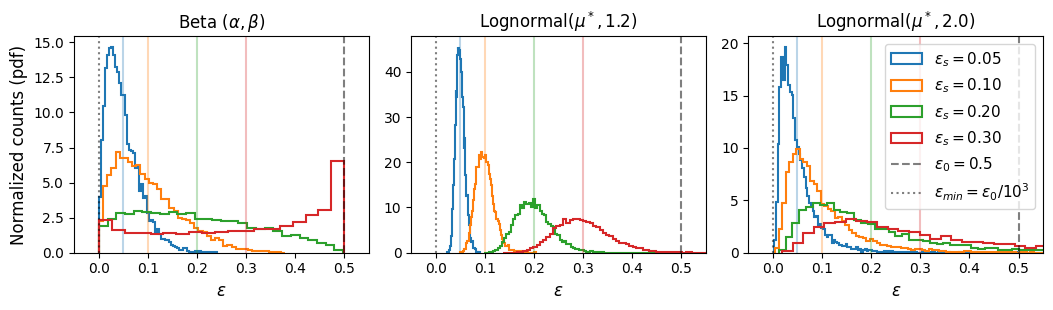

In [386]:
fig, ax = plt.subplots(1, 3, figsize=(10.5,3.2), sharex=True, sharey=False)

for i, epsmean in enumerate([0.05, 0.1, 0.2, 0.3]):
    ax[0].hist(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin).rvs(10000), 
               histtype='step', bins='auto', density=True, lw=1.5)
    ax[1].hist(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin, distribution='lognormal', stepsize_sigma=1.2).rvs(10000), 
               histtype='step', bins='auto', density=True, lw=1.5);
    ax[2].hist(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin, distribution='lognormal', stepsize_sigma=2).rvs(10000), 
               histtype='step', bins='auto', density=True, lw=1.5, label=f'$\epsilon_s={epsmean:0.2f}$');
    for axis in ax: axis.axvline(epsmean, color=f'C{i}', alpha=0.3)
    
for axis in ax: 
    axis.set_xlim(-0.05, eps0*1.1)
    axis.set_xlabel('$\epsilon$', fontsize=12)
    axis.axvline(epsmax, color='k', alpha=0.5, ls='--',  label=f'$\epsilon_0=0.5$');
    axis.axvline(epsmin, color='k', alpha=0.5, ls=':',  label=r'$\epsilon_{min}=\epsilon_0/10^3$');
    
ax[0].set_title(r'Beta ($\alpha, \beta$)')
ax[1].set_title('Lognormal($\mu^*, 1.2$)')
ax[2].set_title('Lognormal($\mu^*, 2.0$)')
ax[2].legend(fontsize=11)
ax[0].set_ylabel('Normalized counts (pdf)', fontsize=12)
plt.tight_layout()
# plt.savefig()

In [396]:
# np.log(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin, distribution='lognormal', stepsize_sigma=1.2).rvs(10000)).std()

In [566]:
epsmean = 0.1
tmp = distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin, distribution='lognormal', stepsize_sigma=1.2).rvs(100000) 
(tmp > 2*epsmean).sum()/tmp.size * 100

0.003

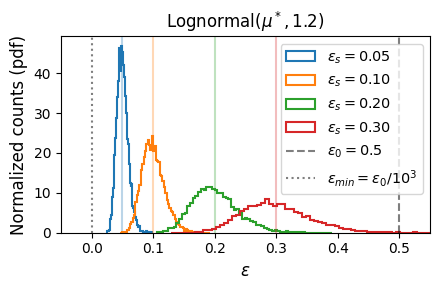

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=True, sharey=False)
ax = [ax]
for i, epsmean in enumerate([0.05, 0.1, 0.2, 0.3]):
    # ax[0].hist(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin).rvs(10000), 
    #            histtype='step', bins='auto', density=True, lw=1.5)
    ax[0].hist(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin, distribution='lognormal', stepsize_sigma=1.2).rvs(10000), 
               histtype='step', bins='auto', density=True, lw=1.5, label=f'$\epsilon_s={epsmean:0.2f}$')
    # ax[2].hist(distributions.setup_stepsize_distribution(epsmean, epsmax, epsmin, distribution='lognormal', stepsize_sigma=2).rvs(10000), 
    #            histtype='step', bins='auto', density=True, lw=1.5, label=f'$\epsilon_s={epsmean:0.2f}$');
    for axis in ax: axis.axvline(epsmean, color=f'C{i}', alpha=0.3)
    
for axis in ax: 
    axis.set_xlim(-0.05, eps0*1.1)
    axis.set_xlabel('$\epsilon$', fontsize=12)
    axis.axvline(epsmax, color='k', alpha=0.5, ls='--',  label=f'$\epsilon_0=0.5$');
    axis.axvline(epsmin, color='k', alpha=0.5, ls=':',  label=r'$\epsilon_{min}=\epsilon_0/10^3$');
    
# ax[0].set_title(r'Beta ($\alpha, \beta$)')
ax[0].set_title('Lognormal($\mu^*, 1.2$)')
# ax[2].set_title('Lognormal($\mu^*, 2.0$)')
ax[0].legend(fontsize=10.4)
ax[0].set_ylabel('Normalized counts (pdf)', fontsize=12)
plt.tight_layout()


# corofu

In [ ]:
# a = np.random.normal(1, 3, 100000)
# b = np.random.normal(a**2, 0.1)
# # plt.hist(b, bins='auto');
# plt.plot(a, b, '.')
a = np.random.normal(1, 1, 100000)
b = np.random.normal(a**2, 0.1)
# plt.hist(b, bins='auto');
plt.plot(a, b, '.')


In [ ]:
plt.show()
D = 10 
r = 0.95
m = np.zeros((D, D))
for i in range(D):
    for j in range(D):
        m[i, j] = r**abs(i-j)
a = np.random.multivariate_normal(np.zeros(D), m, 100000)
# b = np.random.normal(0, 1, 100000)
# plt.hist(a[..., 0], bins='auto');
# plt.hist(b, bins='auto');
# plt.hist(a[..., 5], bins='auto');
plt.plot(a[..., 4], a[..., 5], '.')
plt.plot(a[..., 0], a[..., 1], '.')



In [ ]:
samples = np.load('/mnt/ceph/users/cmodi/atlassampler/rofu-120/nuts/target0.80/samples.npy')
# samples = np.load('/mnt/ceph/users/cmodi/atlassampler/multifunnel-100/nuts/target0.80/samples.npy')
# samples2 = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.80/samples.npy')
# samples3 = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-51/nuts/target0.80/samples.npy')

In [ ]:
plt.hist(3*np.random.normal(0, 1, 100000), histtype='step', color='k', lw=2, density=True, bins='auto')
plt.hist(samples[..., :20].flatten(), bins=100, density=True) ;# samples.shape
# plt.hist(samples2[..., 0].flatten(), bins='auto', density=True, alpha=0.5) ;# samples.shape
# plt.hist(samples3[..., 0].flatten(), bins='auto', density=True, alpha=0.5) ;# samples.shape

In [ ]:
plt.plot(samples[..., 9].flatten(), samples[..., 21].flatten(), '.') ;# samples.shape

In [ ]:
plt.hist(samples[..., 17].flatten(), bins=100) ;

In [ ]:
plt.show()
Dhalf = 10
D = Dhalf* 2
r = 0.95
m = np.zeros((D, D))
for i in range(D):
    for j in range(D):
        m[i, j] = r**abs(i-j)
a = np.random.multivariate_normal(np.zeros(D), m, 1000000).T


f = []
for i in range(Dhalf):
    f.append(np.stack([np.random.normal(0, np.exp(3*a[i]/2)) for _ in range(9)]))
f = np.concatenate(f, axis=0)
r = []
for i in range(Dhalf, D):
    r.append(np.random.normal((a[i]+1)**2, 0.1))
r = np.array(r)


a.shape, f.shape, r.shape
# b = np.random.normal(0, 1, 100000)
# plt.hist(a[..., 0], bins='auto');
# plt.hist(b, bins='auto');
# plt.hist(a[..., 5], bins='auto');
plt.plot(a[4], a[5], '.')
plt.plot(a[0], a[1], '.')

ref = np.concatenate([a, f, r], axis=0).T



In [ ]:
# np.load('/mnt/ceph/users/cmodi/PosteriorDB/corr_normal95-100/samples.npy').shape

In [ ]:
# ref.shape
# np.save('/mnt/ceph/users/cmodi/PosteriorDB/corofu95-120/samples.npy', ref)


In [ ]:
sa = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/corofu2-95-120/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
# sa = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/corofu2-95-120/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])#[:, :10000]
# sa = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/corofu95-60/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
# sa = np.load(f'/mnt/ceph/users/cmodi/atlassampler/corofu95-60/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap-lognormal-stepsig1.2/samples_constrained-0.npy')
sn = np.load(f'/mnt/ceph/users/cmodi/atlassampler/corofu2-95-120/nuts/target0.80/samples.npy')

# sa = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/multifunnel-100/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
# sn = np.load(f'/mnt/ceph/users/cmodi/atlassampler/multifunnel-100//nuts/target0.80/samples.npy')

sa = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-101/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])[:, :10000]
sn = np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-101//nuts/target0.80/samples.npy')[:, :10000]

In [ ]:
sa.shape, sn.shape

In [ ]:
# plt.hist(sa[..., :10].flatten(), bins=100, density=True);
# plt.hist(sn[..., :10].flatten(), bins=100, density=True, alpha=0.5);
plt.hist(sa[..., :1].flatten(), bins=100, density=True);
plt.hist(sn[..., :1].flatten(), bins=100, density=True, alpha=0.5);
# plt.hist(ref[..., :10].flatten(), bins=100, density=True, histtype='step', color='k', lw=2);
plt.hist(ref[..., :10].flatten()*3, bins=100, density=True, histtype='step', color='k', lw=2);


# plt.hist(sa[..., 55:].flatten(), bins=100, density=True);
# plt.hist(sn[..., 55:].flatten(), bins=100, density=True, alpha=0.5);
# # plt.hist(sa[..., :1].flatten(), bins=100, density=True);
# # plt.hist(sn[..., :1].flatten(), bins=100, density=True, alpha=0.5);
# plt.hist(ref[..., 55:].flatten(), bins=100, density=True, histtype='step', color='k', lw=2);
# # plt.hist(ref[..., :10].flatten()*3, bins=100, density=True, histtype='step', color='k', lw=2);

In [ ]:
# print(sa[..., :10].flatten().mean(), sa[..., :10].flatten().std())
# print(sn[..., :10].flatten().mean(), sn[..., :10].flatten().std())
print(sa[..., :1].flatten().mean(), sa[..., :1].flatten().std())
print(sn[..., :1].flatten().mean(), sn[..., :1].flatten().std())
# print(ref[..., :10].flatten().mean(), ref[..., :10].flatten().std())
print(ref[..., :10].flatten().mean()*3, ref[..., :10].flatten().std()*3)

In [ ]:
# plt.boxplot([sa[..., :10].mean(axis=(1)).flatten() - ref[..., :10].mean(), sn[..., :10].mean(axis=(1)).flatten() - ref[..., :10].mean()], showfliers=True);
# plt.boxplot([sa[..., :10].mean(axis=(1)).flatten() - 3*ref[..., :10].mean(), sn[..., :10].mean(axis=(1)).flatten() - 3*ref[..., :10].mean()], showfliers=True);
plt.boxplot([sa[..., :1].mean(axis=(1)).flatten() - 3*ref[..., :10].mean(), sn[..., :1].mean(axis=(1)).flatten() - 3*ref[..., :10].mean()], showfliers=True);
plt.axhline(0, color='k')

In [ ]:
# plt.boxplot([(sa[..., :10]**2).mean(axis=(1)).flatten() - (ref[..., :10]**2).mean(), (sn[..., :10]**2).mean(axis=(1)).flatten() - (ref[..., :10]**2).mean()], showfliers=False);
# plt.boxplot([(sa[..., :10]**2).mean(axis=(1)).flatten() - (9*ref[..., :10]**2).mean(), (sn[..., :10]**2).mean(axis=(1)).flatten() - (9*ref[..., :10]**2).mean()], showfliers=False);
plt.boxplot([(sa[..., :1]**2).mean(axis=(1)).flatten() - (9*ref[..., :10]**2).mean(), (sn[..., :1]**2).mean(axis=(1)).flatten() - (9*ref[..., :10]**2).mean()], showfliers=True);
plt.axhline(0, color='k')

In [ ]:
# plt.boxplot([(sa[..., :10]**2).mean(axis=(1)).flatten() - (ref[..., :10]**2).mean(), (sn[..., :10]**2).mean(axis=(1)).flatten() - (ref[..., :10]**2).mean()], showfliers=False);
plt.boxplot([(sa[..., 110:]**2).mean(axis=(1)).flatten() - (ref[..., 110:]**2).mean(), (sn[..., 110:]**2).mean(axis=(1)).flatten() - (ref[..., 110:]**2).mean()], showfliers=False);
plt.axhline(0, color='k')

# hybrid rosenbrock

In [ ]:
D=1
np.array([np.random.normal(x1**2, 0.1) for _ in range(D-1)]).T

In [ ]:
# x1 = np.random.normal(1, 1/(2*1/20)**0.5, int(1e6))
x1 = np.random.normal(1, 1, int(1e6))
plt.hist(x1, bins=100);
plt.show()
x12 = np.random.normal(x1**2, 0.1)
x13 = np.random.normal(x12**2, 0.1)
x14 = np.random.normal(x13**2, 0.1)
x22 = np.random.normal(x1**2, 0.1)
x23 = np.random.normal(x22**2, 0.1)
x24 = np.random.normal(x23**2, 0.1)


In [ ]:
plt.plot(x23, x12, '.')
plt.show()
# plt.plot(x1, x13, '.')
# plt.show()
# plt.plot(x1, x14, '.')
# plt.show()
# plt.plot(x12, x13, '.')
# plt.show()
# plt.plot(x12, x14, '.')
# plt.show()
# plt.plot(x13, x14, '.')

In [ ]:
D = 3
x = np.random.normal(1, 1, 1000000)
y = []
for i in range((D-1)//2):
    x1 = np.random.normal(x**2, 0.1)
    x2 = np.random.normal(x1**2, 0.1)
    y.append(x1)
    y.append(x2)
y = np.stack(y, axis=1)
x = np.expand_dims(x, axis=1)
# ref_samples = np.concatenate([x, y], axis=1)

In [ ]:
s = np.load('/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/nuts/target0.80/samples.npy')
s2 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])[:, :50000]
# s3 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-2048/samples_constrained-{i}.npy') for i in range(32)])[:, :50000]
s3 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/dr_stepadapt-indep/target0.80-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
# s3 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/dr_stepadapt-indep/target0.80nleap100-lognormal-stepsig1.2-test2/samples_constrained-{i}.npy') for i in range(32)])
# s3 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/dr_stepadapt-indep/target0.80-lognormal-stepsig1.2-test/samples_constrained-{i}.npy') for i in range(32)])

In [ ]:
s.shape, s2.shape, s3.shape

In [ ]:
i = 0
# plt.hist(s[..., i].flatten(), density=True, bins='auto');
# plt.hist(s2[..., i].flatten(), density=True, bins='auto', alpha=0.7);
plt.hist(s3[..., i].flatten(), density=True, bins='auto', alpha=0.7);
plt.hist(ref_samples_rosenbrockhy3[..., i].flatten(), density=True, bins='auto', histtype='step', color='k', lw=2);
# plt.yscale('log')

In [ ]:
s.mean(axis=(0,1)), s2.mean(axis=(0,1)), s3.mean(axis=(0,1)), ref_samples_rosenbrockhy3.mean(axis=(0))

In [ ]:
(s**2).mean(axis=(0,1)), (s2**2).mean(axis=(0,1)), (s3**2).mean(axis=(0,1)), (ref_samples_rosenbrockhy3**2).mean(axis=(0))

In [ ]:
s = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-101/nuts/target0.80/samples.npy')
s2 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-101/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
# s3 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/samples_constrained-{i}.npy') for i in range(32)])[:, :10000]

In [ ]:
plt.hist(s[..., 0].flatten(), bins=100, density=True)
plt.hist(s2[..., 0].flatten(), bins=100, density=True, alpha=0.5);
plt.hist((ref_samples[..., 0]-1).flatten()*3, density=True, bins='auto', histtype='step', color='k', lw=2);


In [ ]:
s[..., 0].mean(), s2[..., 0].mean()

In [ ]:
s[..., 0].std(), s2[..., 0].std()

In [ ]:
# def funnel_rosenbrock_plot(alldata, keystoplot=None):

#     if keystoplot is None: nkeys = len(alldata['funnel-11'].keys())-1
#     else: nkeys = len(keystoplot)
#     if 'funnel-51' in alldata.keys(): n = 3
#     else:  n = 2

#     fig, ax = plt.subplots(n, 4+nkeys, figsize=(6+nkeys*2.5, 2*n), sharex=False, sharey='row')

#     fliers=False

#     for i in range(n):
#         for j in range(2):
#             exp = ['rosenbrock-2', 'funnel-11', 'funnel-51'][i]
#             data = alldata[exp]
#             refs = reference_samples[exp]

#             toplot, toplot2, lbls = [], [], []
#             if keystoplot is None: keystoplot = data.keys()
#             for key in keystoplot:
#                 if key == 'ref': continue
#                 if key not in data.keys(): continue
#                 if j == 0:
#                     toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
#                     toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
#                     ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
#                     ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
#                     ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)

#                 if j == 1:
#                     toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
#                     toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
#                     ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
#                     ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
#                     ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
#                 lbls.append(key)
#                 # if 'dist' not in key: ikey += 1 

#             ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
#                         boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
#             ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
#                         boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);


#     for axis in ax[-1]:
#         axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

#     ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
#     ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
#     # for axis in ax.flatten():
#     #     axis.grid(which='both', lw=0.1)
#     #     if baselines is not None: axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)

#     for i in range(n):
        
#         exp = ['rosenbrock-2', 'funnel-11'][i]
#         data = alldata[exp]
#         refs = reference_samples[exp]
#         if keystoplot is None: keystoplot = data.keys()
#         for j, key in enumerate(keystoplot):
#             if key == 'ref': continue
#             if key not in data.keys(): continue
#             j -= 1
#             ax[i, j+4].hist(refs[..., 0].flatten(), histtype='step', color='k', bins='auto', density=True)
#             ax[i, j+4].hist(data[key][-1][..., 0].flatten(), bins='auto', density=True)
#             if i ==0 : ax[i, j].set_title(key)
#             ax[i, 0].set_ylabel(f'{exp}')
#     return fig, ax


In [ ]:
alldata['funnel-51']['atlas-logn-unif'][-1][...,0].shape #mean(), alldata['funnel-51']['atlas-logn-unif'][-1][...,0].std()

In [ ]:
exp = 'irt_2pl'
s = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80/stepsize.npy')exp = 'irt_2pl'
s = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80/stepsize.npy')
s2 = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80-stepfac1.25//stepsize.npy')
plt.boxplot([s, s2]);

# GIST U-turns

In [25]:
sys.path.append('../experiments/')
import models

SAVEFOLDER = '/mnt/ceph/users/cmodi/atlassampler/'
REFERENCE_FOLDER = "/mnt/ceph/users/cmodi/PosteriorDB/"
BRIDGESTAN = "/mnt/home/cmodi/Research/Projects/bridgestan/"
MODELDIR = '../'
reference_path =  f'{REFERENCE_FOLDER}/'
from atlassampler import HMC_Uturn


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
model, D, lp, lp_g, ref_samples, files = models.stan_model('funnel', 2,
                                                           bridgestan_path=BRIDGESTAN,
                                                           model_directory=MODELDIR,
                                                           reference_samples_path=reference_path,
                                                           run_nuts=False)



..//stan/funnel.data.json
{'D': 2}
Exception in loading reference samples:  [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/PosteriorDB///funnel-3//samples.npy'
Generate samples analytically


n_leapfrog argument is only used to adapt stepsize in U-turn sampler
Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100


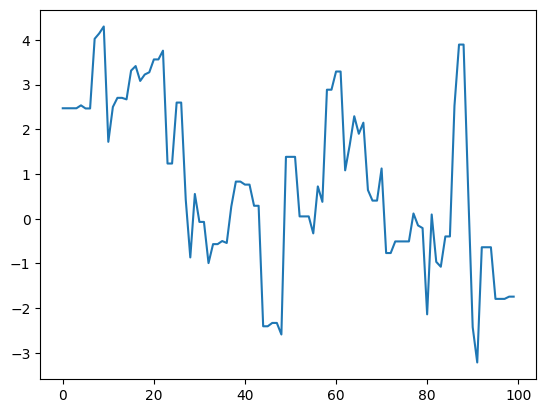

In [27]:
# Start run                                                                                                                                         
offset = 0.
step_size = 0.1
n_samples = 100 
np.random.seed(0)

q0 = np.random.normal(size=D)               
kernel = HMC_Uturn(D, lp, lp_g,
               mass_matrix = np.eye(D),
               offset = offset,
               min_nleapfrog = 3,
               max_nleapfrog = 1024)

sampler = kernel.sample(q0,
                        seed = 1,
                        step_size = step_size ,
                        n_samples = n_samples,
                        n_burnin = 0,
                        n_stepsize_adapt = 0)

plt.plot(sampler.samples[:, 0])                   

## Plot a GIST trajectory

In [126]:
offset = 0.5
for j in range(100):
    q0 = np.random.normal(size=D)
    p0 = np.random.normal(size=D)
    Nuturn, qs, ps, gs, success = kernel.nuts_criterion(q0, p0, step_size)
    nleapfrog, lp1 = kernel.nleapfrog_sample_and_lp(Nuturn, offset=offset)
    q1, p1, qlist, glist = qs[nleapfrog], ps[nleapfrog], qs, gs

    # Go backward                                                                                                                           
    Nuturn_rev, qs2 = kernel.nuts_criterion(q1, -p1, step_size)[:2]
    nleapfrog2, lp2 = kernel.nleapfrog_sample_and_lp(Nuturn_rev, offset=offset, nleapfrog=nleapfrog)
    if lp2 == -np.inf: pass
    else: break

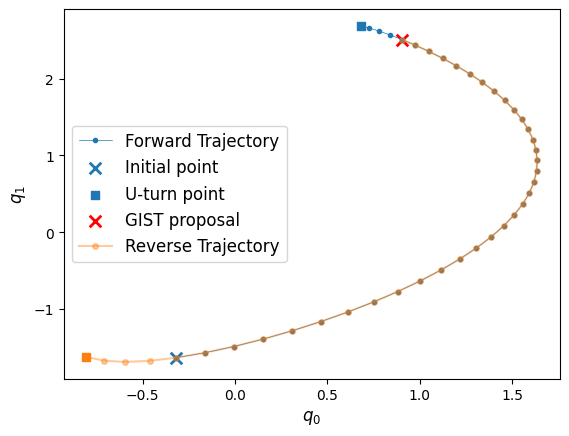

In [136]:

plt.plot(np.array(qs)[:, 0], np.array(qs)[:, 1], 'C0', marker='.', label='Forward Trajectory', lw=0.5)
plt.scatter(np.array(qs)[0, 0], np.array(qs)[0, 1], color='C0', marker='x', s=70, linewidth=2,  label='Initial point')
plt.scatter(np.array(qs)[-1, 0], np.array(qs)[-1, 1], color='C0', marker='s', s=40, label='U-turn point')
plt.scatter(np.array(qs)[nleapfrog, 0], np.array(qs)[nleapfrog, 1], color='r', marker='x', s=70, linewidth=2, label='GIST proposal')

plt.plot(np.array(qs2)[:, 0], np.array(qs2)[:, 1], 'C1', marker ='.', alpha=0.4, ms=8, label='Reverse Trajectory')
# plt.plot(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], 'C1s', ms=6)
plt.scatter(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], color='C1', marker='s', s=40)
plt.xlabel(r'$q_0$', fontsize=12)
plt.ylabel(r'$q_1$', fontsize=12)
plt.legend(loc=6, fontsize=12)
# plt.savefig('./figs/gist_traj.png')
# plt.savefig('./figs/gist_traj.pdf')


## plot a sub-uturn

-3.2580965380214817 -inf
51 35 42


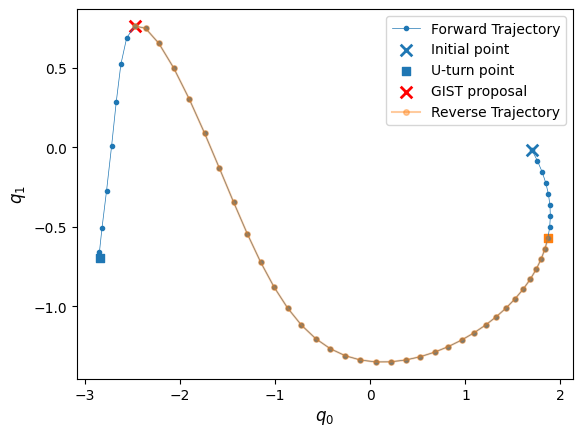

In [124]:
offset = 0.5
for j in range(100):
    q0 = np.random.normal(size=D)
    p0 = np.random.normal(size=D)
    Nuturn, qs, ps, gs, success = kernel.nuts_criterion(q0, p0, step_size)
    nleapfrog, lp1 = kernel.nleapfrog_sample_and_lp(Nuturn, offset=offset)
    q1, p1, qlist, glist = qs[nleapfrog], ps[nleapfrog], qs, gs

    # Go backward                                                                                                                           
    Nuturn_rev, qs2 = kernel.nuts_criterion(q1, -p1, step_size)[:2]
    nleapfrog2, lp2 = kernel.nleapfrog_sample_and_lp(Nuturn_rev, offset=offset, nleapfrog=nleapfrog)
    if lp2 == -np.inf:
        print(lp1, lp2)
        print(Nuturn, Nuturn_rev, nleapfrog)
        qs = np.array(qs)
        qs2 = np.array(qs2)
        break
        
    
plt.plot(np.array(qs)[:, 0], np.array(qs)[:, 1], 'C0', marker='.', label='Forward Trajectory', lw=0.5)
plt.scatter(np.array(qs)[0, 0], np.array(qs)[0, 1], color='C0', marker='x', s=70, linewidth=2,  label='Initial point')
plt.scatter(np.array(qs)[-1, 0], np.array(qs)[-1, 1], color='C0', marker='s', s=40, label='U-turn point')
plt.scatter(np.array(qs)[nleapfrog, 0], np.array(qs)[nleapfrog, 1], color='r', marker='x', s=70, linewidth=2, label='GIST proposal')

plt.plot(np.array(qs2)[:, 0], np.array(qs2)[:, 1], 'C1', marker ='.', alpha=0.4, ms=8, label='Reverse Trajectory')
# plt.plot(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], 'C1s', ms=6)
plt.scatter(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], color='C1', marker='s', s=40)
plt.xlabel(r'$q_0$', fontsize=12)
plt.ylabel(r'$q_1$', fontsize=12)
plt.legend()
# plt.savefig('./figs/gist_subuturn_traj.png')
# plt.savefig('./figs/gist_subuturn_traj.pdf')


In [19]:

plt.plot(np.array(qs)[:, 0], np.array(qs)[:, 1], 'C0', marker='.', label='Forward Trajectory', lw=0.5)
plt.scatter(np.array(qs)[0, 0], np.array(qs)[0, 1], color='C0', marker='x', s=70, linewidth=2,  label='Initial point')
plt.scatter(np.array(qs)[-1, 0], np.array(qs)[-1, 1], color='C0', marker='s', s=40, label='U-turn point')
plt.scatter(np.array(qs)[nleapfrog, 0], np.array(qs)[nleapfrog, 1], color='r', marker='x', s=70, linewidth=2, label='GIST proposal')

plt.plot(np.array(qs2)[:, 0], np.array(qs2)[:, 1], 'C1', marker ='.', alpha=0.4, ms=8, label='Reverse Trajectory')
# plt.plot(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], 'C1s', ms=6)
plt.scatter(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], color='C1', marker='s', s=40)
plt.xlabel(r'$q_0$', fontsize=12)
plt.ylabel(r'$q_1$', fontsize=12)
plt.legend()
# plt.savefig('./figs/gist_subuturn_traj.png')
# plt.savefig('./figs/gist_subuturn_traj.pdf')


NameError: name 'qs' is not defined

In [24]:
alldata['funnel-11'].keys()

dict_keys(['ref', 'nuts', 'nuts0.95', 'atlas-logn-unif', 'atlas-logn-unif-0.6'])

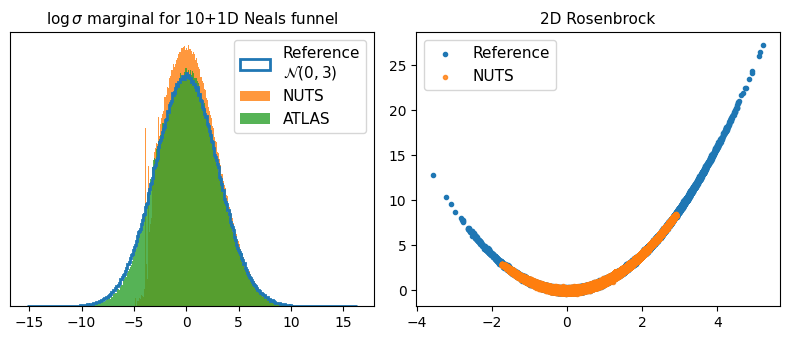

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
# ax[0].hist(ref_samples_funnel[..., 0].flatten(), bins='auto', histtype='step', color='C0', lw=2, density=True);
ax[0].hist(np.random.normal(0, 3, 1000000), bins='auto', histtype='step', color='C0', lw=2, density=True, label='Reference\n$\mathcal{N}(0, 3)$');
ax[0].hist(alldata['funnel-11']['nuts'][-1][...,0].flatten(), bins='auto', alpha=0.8, color='C1', density=True, label='NUTS');
ax[0].hist(alldata['funnel-11']['atlas-logn-unif-0.6'][-1][...,0].flatten(), bins='auto', alpha=0.8, color='C2', density=True, label='ATLAS');
ax[1].scatter(ref_samples_rosenbrock[:, 0], ref_samples_rosenbrock[:, 1], marker='.',  label='Reference');
ax[1].scatter(alldata['rosenbrock-2']['nuts'][-1][..., 0][::10].flatten(), alldata['rosenbrock-2']['nuts'][-1][..., 1][::10].flatten(), marker='.', alpha=0.8, label='NUTS');
ax[0].set_title("$\log \sigma$ marginal for 10+1D Neals funnel", fontsize=11)
ax[1].set_title("2D Rosenbrock", fontsize=11)
ax[0].get_yaxis().set_ticks([])
for axis in ax:
    axis.legend(fontsize=11)
plt.tight_layout()
# plt.savefig('./figs/nuts_failure.png')
# plt.savefig('./figs/nuts_failure.pdf')

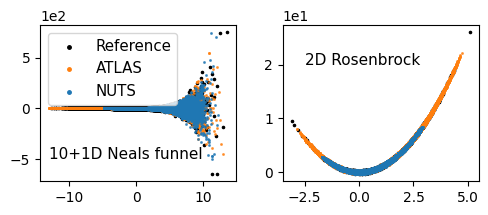

In [85]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
fig, ax = plt.subplots(1, 2, figsize=(5, 2.25))
# fig, ax = plt.subplots(2, 1, figsize=(3, 4.2))
# ax[0].hist(ref_samples_funnel[..., 0].flatten(), bins='auto', histtype='step', color='C0', lw=2, density=True);
# ax[0].t(np.random.normal(0, 3, 1000000), bins='auto', histtype='step', color='C0', lw=2, density=True, label='Reference\n$\mathcal{N}(0, 3)$');
refplot = ref_samples_funnel[::1]
ax[0].scatter(refplot[:, 0], refplot[:, 1], color='k',  marker='.',  s=10);
s = alldata['funnel-11']['atlas-logn-unif-0.6'][-1][::10]
ax[0].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C1', marker='.', s=5, alpha=0.7);
s = alldata['funnel-11']['nuts'][-1][::10]
ax[0].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C0', marker='.', s=5, alpha=0.7);

refplot = ref_samples_rosenbrock[::11]
ax[1].scatter(refplot[:, 0], refplot[:, 1], color='k',  marker='.', s=10, label='Reference');
# ax[1].scatter(ref_samples_rosenbrock[::10, 0], ref_samples_rosenbrock[:, 1], color='k',  marker='.',  label='Reference');
s = alldata['rosenbrock-2']['atlas-logn-unif-0.6'][-1][::10]
ax[1].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C1', marker='.', s=5, alpha=0.7, label='ATLAS');
s = alldata['rosenbrock-2']['nuts'][-1][::10]
ax[1].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C0',  marker='.', s=5, alpha=0.7, label='NUTS');
# ax[1].scatter(alldata['rosenbrock-2']['atlas-logn-unif-0.6'][-1][..., 0][::10].flatten(), alldata['rosenbrock-2']['atlas-logn-unif-0.6'][-1][..., 1][::10].flatten(),
#               marker='.', alpha=0.7, label='ATLAS');
# ax[1].scatter(alldata['rosenbrock-2']['nuts'][-1][..., 0][::10].flatten(), alldata['rosenbrock-2']['nuts'][-1][..., 1][::10].flatten(),
#               marker='.', alpha=0.7, label='NUTS');
# ax[0].set_title("10+1D Neals funnel", fontsize=11)
# ax[1].set_title("2D Rosenbrock", fontsize=11)
ax[0].text(-13, -500, "10+1D Neals funnel", fontsize=11)
ax[1].text(-2.5, 20, "2D Rosenbrock", fontsize=11)
# ax[0].get_yaxis().set_ticks([])
# ax[1].get_yaxis().set_ticks([])
# for axis in ax:
#     axis.legend(loc=2, ncol=1, fontsize=11)

ax[0].scatter(np.NaN,  np.NaN, color='k', marker='.', s=25, alpha=1, label='Reference');
ax[0].scatter(np.NaN,  np.NaN, color='C1', marker='.', s=25, alpha=1, label='ATLAS');
ax[0].scatter(np.NaN,  np.NaN, color='C0', marker='.', s=25, alpha=1, label='NUTS');
ax[0].legend(loc=2, ncol=1, fontsize=10.8)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-1, 0))
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-1, 0))
plt.tight_layout()
# plt.savefig('./figs/nuts_failure.png')
# plt.savefig('./figs/nuts_failure.pdf')

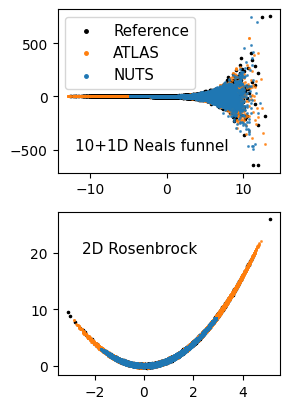

In [79]:
# fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
# fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
fig, ax = plt.subplots(2, 1, figsize=(3, 4.2))
# ax[0].hist(ref_samples_funnel[..., 0].flatten(), bins='auto', histtype='step', color='C0', lw=2, density=True);
# ax[0].t(np.random.normal(0, 3, 1000000), bins='auto', histtype='step', color='C0', lw=2, density=True, label='Reference\n$\mathcal{N}(0, 3)$');
refplot = ref_samples_funnel[::1]
ax[0].scatter(refplot[:, 0], refplot[:, 1], color='k',  marker='.',  s=10);
s = alldata['funnel-11']['atlas-logn-unif-0.6'][-1][::10]
ax[0].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C1', marker='.', s=5, alpha=0.7);
s = alldata['funnel-11']['nuts'][-1][::10]
ax[0].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C0', marker='.', s=5, alpha=0.7);

refplot = ref_samples_rosenbrock[::11]
ax[1].scatter(refplot[:, 0], refplot[:, 1], color='k',  marker='.', s=10, label='Reference');
# ax[1].scatter(ref_samples_rosenbrock[::10, 0], ref_samples_rosenbrock[:, 1], color='k',  marker='.',  label='Reference');
s = alldata['rosenbrock-2']['atlas-logn-unif-0.6'][-1][::10]
ax[1].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C1', marker='.', s=5, alpha=0.7, label='ATLAS');
s = alldata['rosenbrock-2']['nuts'][-1][::10]
ax[1].scatter(s[..., 0].flatten(), s[..., 1].flatten(),  color='C0',  marker='.', s=5, alpha=0.7, label='NUTS');
# ax[1].scatter(alldata['rosenbrock-2']['atlas-logn-unif-0.6'][-1][..., 0][::10].flatten(), alldata['rosenbrock-2']['atlas-logn-unif-0.6'][-1][..., 1][::10].flatten(),
#               marker='.', alpha=0.7, label='ATLAS');
# ax[1].scatter(alldata['rosenbrock-2']['nuts'][-1][..., 0][::10].flatten(), alldata['rosenbrock-2']['nuts'][-1][..., 1][::10].flatten(),
#               marker='.', alpha=0.7, label='NUTS');
# ax[0].set_title("10+1D Neals funnel", fontsize=11)
# ax[1].set_title("2D Rosenbrock", fontsize=11)
ax[0].text(-12, -500, "10+1D Neals funnel", fontsize=11)
ax[1].text(-2.5, 20, "2D Rosenbrock", fontsize=11)
# ax[0].get_yaxis().set_ticks([])
# ax[1].get_yaxis().set_ticks([])
# for axis in ax:
#     axis.legend(loc=2, ncol=1, fontsize=11)

ax[0].scatter(np.NaN,  np.NaN, color='k', marker='.', s=25, alpha=1, label='Reference');
ax[0].scatter(np.NaN,  np.NaN, color='C1', marker='.', s=25, alpha=1, label='ATLAS');
ax[0].scatter(np.NaN,  np.NaN, color='C0', marker='.', s=25, alpha=1, label='NUTS');
ax[0].legend(loc=2, ncol=1, fontsize=10.8)
plt.tight_layout()
# plt.savefig('./figs/nuts_failure.png')
# plt.savefig('./figs/nuts_failure.pdf')

In [236]:
alldata['funnel-11']['nuts'][-1].shape

(32, 49999, 11)

In [235]:
alldata['stochastic_volatility']['nuts'][-1].shape

(32, 1999, 503)

# Cumulative error

In [98]:
tmp = np.cumsum(alldata['funnel-11']['atlas-logn-unif'][3][..., 0], axis=1)/(1+np.arange(alldata['funnel-11']['atlas-logn-unif'][3].shape[1]))
tmp2 = np.cumsum(alldata['funnel-11']['prop-atlas-logn-unif'][3][..., 0], axis=1)/(1+np.arange(alldata['funnel-11']['atlas-logn-unif'][3].shape[1]))


[]

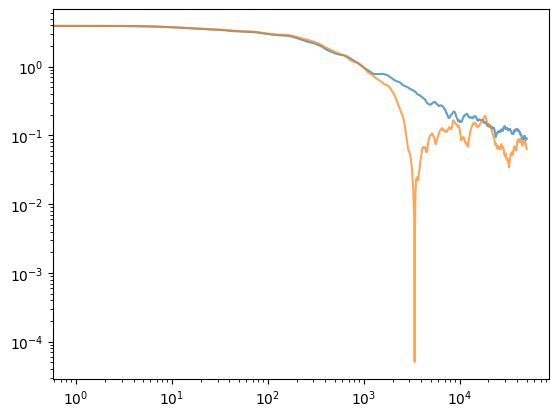

In [97]:
plt.plot(abs(tmp.mean(axis=0)), 'C0', alpha=0.7);
plt.plot(abs(tmp2.mean(axis=0)), 'C1', alpha=0.7);
plt.loglog()
# plt.ylim(1e-3, 10)

[]

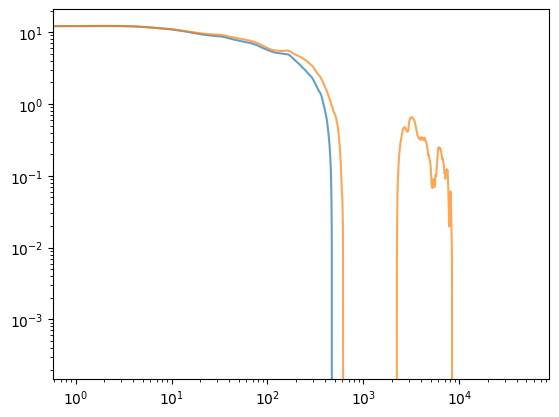

In [108]:
tmp = np.cumsum(alldata['funnel-51']['atlas-logn-unif'][3][..., 0]**2, axis=1)/(1+np.arange(alldata['funnel-11']['atlas-logn-unif'][3].shape[1]))
tmp2 = np.cumsum(alldata['funnel-51']['prop-atlas-logn-unif'][3][..., 0]**2, axis=1)/(1+np.arange(alldata['funnel-11']['atlas-logn-unif'][3].shape[1]))


plt.plot(abs(tmp.mean(axis=0)-9), 'C0', alpha=0.7);
plt.plot(abs(tmp2.mean(axis=0)-9), 'C1', alpha=0.7);
plt.loglog()
plt.ylim(1e-3, 10)

(0.001, 10)

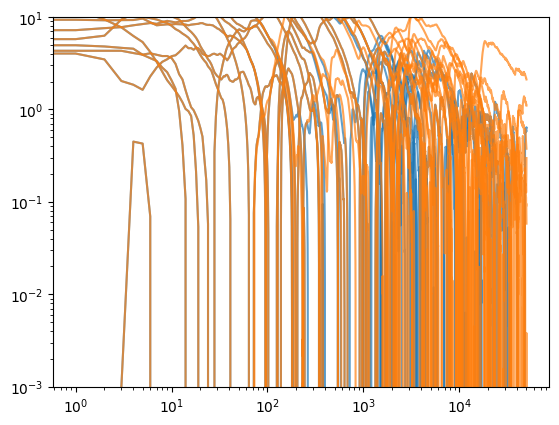

In [104]:
plt.plot(abs(tmp).T-9, 'C0', alpha=0.7);
plt.plot(abs(tmp2).T-9, 'C1', alpha=0.7);
plt.loglog()
plt.ylim(1e-3, 10)

In [65]:
s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
s1 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac1.1/samples_constrained-{i}.npy') for i in range(32)])
# s1 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-indep/target0.60-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
s2 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-indep/target0.60-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])

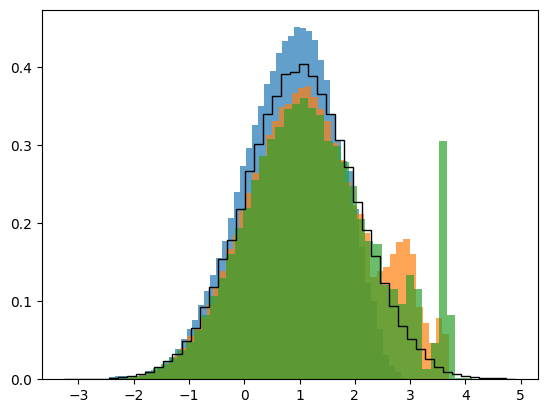

In [66]:
plt.hist(s[..., 0].flatten(), bins=50, alpha=0.7, density=True);
plt.hist(s1[..., 0].flatten(), bins=50, alpha=0.7, density=True);
plt.hist(s2[..., 0].flatten(), bins=50, alpha=0.7, density=True);
plt.hist(np.random.normal(1, 1, 100000), color='k', histtype='step', density=True, bins=50);

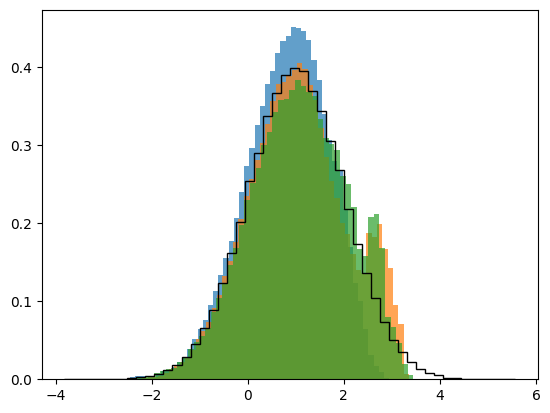

In [63]:
s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
plt.hist(s[..., 0].flatten(), bins=50, alpha=0.7, density=True);
s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-nladapt200/samples_constrained-{i}.npy') for i in range(32)])
plt.hist(s[..., 0].flatten(), bins=50, alpha=0.7, density=True);
s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-3/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-nladapt500/samples_constrained-{i}.npy') for i in range(32)])
plt.hist(s[..., 0].flatten(), bins=50, alpha=0.7, density=True);
plt.hist(np.random.normal(1, 1, 100000), color='k', histtype='step', density=True, bins=50);

# compare with DRHMC

In [279]:
exp = 'rosenbrock-2'
ref = ref_samples_rosenbrock.copy()
exp = 'rosenbrockhy3-3'
ref = ref_samples_rosenbrockhy3.copy()
exp = 'funnel-51'
# exp = 'multifunnel-100'
ref = ref_samples_funnel.copy()

# exp = 'stochastic_volatility'
# exp = 'irt_2pl'
# exp = 'glmm-poisson'

snuts = alldata[exp]['nuts'][-1].copy()
gnuts = alldata[exp]['nuts'][0].copy()
satlas = alldata[exp]['atlas-logn-unif'][-1].copy()
gatlas = alldata[exp]['atlas-logn-unif'][0].copy()
ss, gg = [], []
# for f in [2, 5, 10]:
for f in [2, 5, 10]:
# for f in [2]:
    s = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/drhmc_nout-indep/sfac{f:0.1f}-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
    g = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/drhmc_nout-indep/sfac{f:0.1f}-prob1-ctraj2/gradcounts-{i}.npy') for i in range(32)])
    ss.append(s)
    gg.append(g)

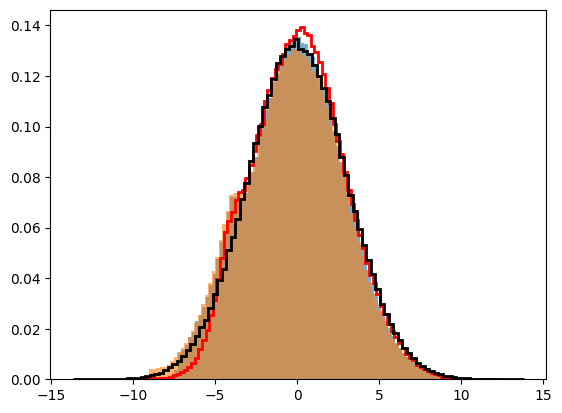

In [280]:
for s in ss[1:]:
    plt.hist(s[..., 0].flatten(), density=True, bins=100, alpha=0.6);
plt.hist(satlas[..., 0].flatten(), density=True, bins=100, histtype='step', lw=2, color='r');
plt.hist(ref[..., 0].flatten(), density=True, bins=100, histtype='step', lw=2, color='k');

In [281]:
for g in gg: 
    print(g.sum()/gnuts.sum())
print('vs', gatlas.sum()/gnuts.sum())


1.301575979315046
2.023128337750492
2.6660445636353636
vs 1.8236922


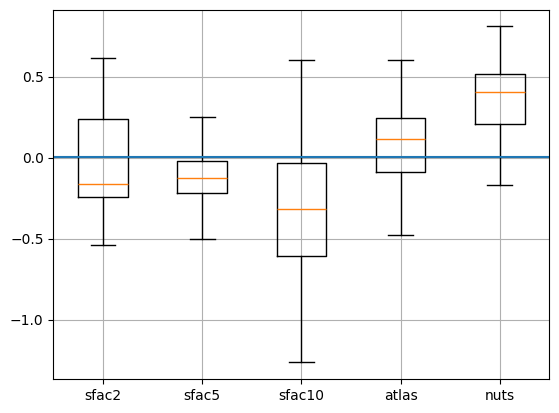

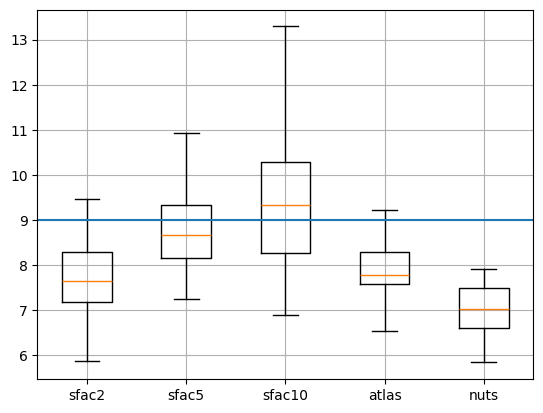

In [282]:
idx = 0
lbls = [f'sfac{i}' for i in [2, 5, 10]] + ['atlas', 'nuts']
plt.boxplot([(i[..., idx]**1).mean(axis=1) for i in ss]  + 
            [(satlas[..., idx]**1).mean(axis=1)] +
            [(snuts[..., idx]**1).mean(axis=1)] , 
            # [(suturn[..., idx]**1).mean(axis=1)] ,
            showfliers=False, labels=lbls);
plt.axhline((ref[..., idx]**1).mean())
plt.grid()
plt.show()
plt.boxplot([(i[..., idx]**2).mean(axis=1) for i in ss] +
            [(satlas[..., idx]**2).mean(axis=1)] + 
            [(snuts[..., idx]**2).mean(axis=1)],
            # [(suturn[..., idx]**2).mean(axis=1)] ,
            showfliers=False, labels=lbls);
plt.axhline((ref[..., idx]**2).mean())
plt.grid()

In [141]:
suturn = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/uturn/offset1.00/samples_constrained-{i}.npy') for i in range(32)])
guturn = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/uturn/offset1.00/gradcounts-{i}.npy') for i in range(32)])

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/multifunnel-100/uturn/offset1.00/samples_constrained-0.npy'

In [ ]:
for g in gg: 
    print(g.sum()/gnuts.sum())
print('vs', gatlas.sum()/gnuts.sum())
print('vs NoUT', guturn.sum()/gnuts.sum())

In [ ]:
plt.boxplot([get_rmses(i, reference_samples[exp])[0][0] for i in ss] + 
            [get_rmses(satlas, reference_samples[exp])[0][0]] + 
            [get_rmses(suturn, reference_samples[exp])[0][0]] + 
            [get_rmses(snuts, reference_samples[exp])[0][0]], 
            showfliers=False
           );
plt.show()
plt.boxplot([get_rmses(i, reference_samples[exp])[0][1] for i in ss] + 
            [get_rmses(satlas, reference_samples[exp])[0][1]] + 
            [get_rmses(suturn, reference_samples[exp])[0][1]] + 
            [get_rmses(snuts, reference_samples[exp])[0][1]],
            showfliers=False
           );

In [632]:
idx = 112 
print(az.ess(satlas[..., idx])/ az.ess(snuts[..., idx]), )
az.ess(suturn[..., idx])/ az.ess(snuts[..., idx])

IndexError: index 112 is out of bounds for axis 2 with size 45

In [633]:
for g in gg: 
    print(g.sum()/gnuts.sum())
print('vs', gatlas.sum()/gnuts.sum())

1.3394008585888664
1.5028290134599633
1.8103783619399452
vs 1.3516374


## make table

In [456]:
gdict = {}
qdict = {}
# q2dict = {}
p0, p1 = 20, 80

for iexp, exp in enumerate(['rosenbrock-2', 'rosenbrockhy3-3', 'funnel-11', 'funnel-51', 'multifunnel-100']):

    ref = reference_samples[exp]
    gs = {}
    ss = {}
    snuts = alldata[exp]['nuts'][-1].copy()
    gnuts = alldata[exp]['nuts'][0].copy()
    
    # snuts95 = alldata[exp]['nuts0.95'][-1].copy()
    # gnuts95 = alldata[exp]['nuts0.95'][0].copy()
    # err  = get_rmses(snuts95, ref)[0]
    # ss['nuts95'] =  [np.percentile(err[0], [10, 50, 90]),  np.percentile(err[1], [10, 50, 90])] 
    # gs['nuts95'] = gatlas.sum()/gnuts.sum()
    
    satlas = alldata[exp]['atlas-logn-unif'][-1].copy()
    gatlas = alldata[exp]['atlas-logn-unif'][0].copy()
    err  = get_rmses(satlas, ref)[1]
    ss['atlas'] =  [np.percentile(err[0][:, 0], [p0, 50, p1]),  np.percentile(err[1][:, 0], [p0, 50, p1])] 
    gs['atlas'] = gatlas.sum()/gnuts.sum()
    for f in [2, 5, 10]:
    # for f in [5, 10]:
    # for f in [2]:
        s = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/drhmc_nout-indep/sfac{f:0.1f}-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
        g = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/drhmc_nout-indep/sfac{f:0.1f}-prob1-ctraj2/gradcounts-{i}.npy') for i in range(32)])
        err  = get_rmses(s, ref)[1]
        gs[f'drhmc-{f}'] = g.sum()/gnuts.sum()
        ss[f'drhmc-{f}'] = [np.percentile(err[0][:, 0], [p0, 50, p1]), np.percentile(err[1][:, 0], [p0, 50, p1])] 
        
    gdict[exp] = gs.copy()
    qdict[exp ]= ss.copy()

In [446]:
# # gdict = {}
# # qdict = {}
# # q2dict = {}
# # p0, p1 = 20, 80

# for iexp, exp in enumerate(['corr_normal95-100', 'ill_normal-100', 'hmm', 'arK', 'lotka_volterra', 'glmm-poisson', 'irt_2pl', 'stochastic_volatility']):

#     ref = reference_samples[exp]
#     if exp == 'lotka_volterra': nchains = 30 
#     else: nchains = 32
#     gs = {}
#     ss = {}
#     try:
#         snuts = alldata[exp]['nuts'][-1].copy()
#         gnuts = alldata[exp]['nuts'][0].copy()
#         satlas = alldata[exp]['atlas-logn-unif'][-1].copy()
#         gatlas = alldata[exp]['atlas-logn-unif'][0].copy()
#         err  = get_rmses(satlas, ref)[0]
#         # ss['atlas'] =  [np.percentile(err[0], [p0, 50, p1]),  np.percentile(err[1], [p0, 50, p1])] 
#         gs['atlas'] = gatlas.sum()/gnuts.sum()
#         # for f in [2, 5, 10]:
#         for f in [2, 5, 10]:
#         # for f in [2]:
#             s = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/drhmc_nout-indep/sfac{f:0.1f}-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(nchains)])
#             g = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/drhmc_nout-indep/sfac{f:0.1f}-prob1-ctraj2/gradcounts-{i}.npy') for i in range(nchains)])
#             err  = get_rmses(s, ref)[1]
#             gs[f'drhmc-{f}'] = g.sum()/gnuts.sum()
#             # ss[f'drhmc-{f}'] = [np.percentile(err[0][:, 0], [p0, 50, p1]), np.percentile(err[1][:, 0], [p0, 50, p1])] 
#         gdict[exp] = gs.copy()
#         qdict[exp ]= ss.copy()
#     except Exception as e:
#         print(e)

In [457]:
print(['Algorithm', 'Atlas', 'DRHMC (a=2)', 'DRHMC (a=5)', 'DRHMC (a=10)'])
print()
# for key in gdict:
#     tp = [key]
#     for k in gdict[key]:
#         # tp.append(f"({qdict[key][k][0]}), {gdict[key][k]:0.2f}")
#         tp.append(f"{gdict[key][k]:0.2f}")
#         # tp.append()
#     print(tp)

print()
for key in qdict:
    if 'multifunnel' in key: continue
    tp = [key]
    for k in qdict[key]:
        tp.append(f"{qdict[key][k][0][1]:0.2f} ({qdict[key][k][0][0]:0.2f}, {qdict[key][k][0][2]:0.2f})")
    print(tp)
    tp = [key + '(sq)']
    for k in qdict[key]:
        tp.append(f"{qdict[key][k][1][1]:0.2f} ({qdict[key][k][1][0]:0.2f}, {qdict[key][k][1][2]:0.2f})")
    print(tp)
    
# print()
# for key in qdict:
#     tp = [key + r'$(\theta^2)$)']
#     for k in qdict[key]:
#         tp.append(f"{qdict[key][k][1][1]:0.2f} ({qdict[key][k][1][0]:0.2f}, {qdict[key][k][1][2]:0.2f})")
#     print(tp)

['Algorithm', 'Atlas', 'DRHMC (a=2)', 'DRHMC (a=5)', 'DRHMC (a=10)']


['rosenbrock-2', '0.00 (-0.07, 0.06)', '-0.05 (-0.11, 0.01)', '0.06 (-0.01, 0.11)', '0.03 (-0.02, 0.09)']
['rosenbrock-2(sq)', '-0.00 (-0.07, 0.06)', '-0.11 (-0.16, -0.03)', '0.07 (-0.02, 0.12)', '0.01 (-0.05, 0.12)']
['rosenbrockhy3-3', '-0.15 (-0.27, 0.25)', '-0.34 (-0.45, 0.08)', '-0.17 (-0.33, -0.08)', '-0.11 (-0.24, 0.10)']
['rosenbrockhy3-3(sq)', '-0.21 (-0.34, 0.25)', '-0.43 (-0.48, -0.12)', '-0.22 (-0.35, -0.11)', '-0.19 (-0.32, 0.01)']
['funnel-11', '0.04 (-0.02, 0.08)', '0.11 (0.06, 0.16)', '0.01 (-0.02, 0.06)', '-0.01 (-0.06, 0.04)']
['funnel-11(sq)', '-0.07 (-0.09, -0.04)', '-0.16 (-0.18, -0.11)', '-0.06 (-0.10, -0.04)', '-0.02 (-0.06, 0.02)']
['funnel-51', '0.04 (-0.09, 0.09)', '-0.05 (-0.10, 0.08)', '-0.04 (-0.11, 0.02)', '-0.11 (-0.23, 0.01)']
['funnel-51(sq)', '-0.10 (-0.12, -0.05)', '-0.11 (-0.16, -0.05)', '-0.03 (-0.08, 0.05)', '0.03 (-0.06, 0.12)']


| Algorithm            | rosenbrock-2          | rosenbrock-2(sq)       | rosenbrockhy3-3        | rosenbrockhy3-3(sq)    | funnel-11             | funnel-11(sq)         | funnel-51             | funnel-51(sq)         |
|----------------------|-----------------------|------------------------|------------------------|------------------------|-----------------------|-----------------------|-----------------------|-----------------------|
| Atlas               | 0.00 (-0.07, 0.06)    | -0.00 (-0.07, 0.06)    | -0.15 (-0.27, 0.25)    | -0.21 (-0.34, 0.25)    | 0.04 (-0.02, 0.08)    | -0.07 (-0.09, -0.04)  | 0.04 (-0.09, 0.09)    | -0.10 (-0.12, -0.05)  |
| DRHMC (a=2)         | -0.05 (-0.11, 0.01)   | -0.11 (-0.16, -0.03)   | -0.34 (-0.45, 0.08)    | -0.43 (-0.48, -0.12)   | 0.11 (0.06, 0.16)     | -0.16 (-0.18, -0.11)  | -0.05 (-0.10, 0.08)   | -0.11 (-0.16, -0.05)  |
| DRHMC (a=5)         | 0.06 (-0.01, 0.11)    | 0.07 (-0.02, 0.12)     | -0.17 (-0.33, -0.08)   | -0.22 (-0.35, -0.11)   | 0.01 (-0.02, 0.06)    | -0.06 (-0.10, -0.04)  | -0.04 (-0.11, 0.02)   | -0.03 (-0.08, 0.05)   |
| DRHMC (a=10)        | 0.03 (-0.02, 0.09)    | 0.01 (-0.05, 0.12)     | -0.11 (-0.24, 0.10)    | -0.19 (-0.32, 0.01)    | -0.01 (-0.06, 0.04)   | -0.02 (-0.06, 0.02)   | -0.11 (-0.23, 0.01)   | 0.03 (-0.06, 0.12)    |


| Algorithm             | rosenbrock-2 | rosenbrockhy3-3 | funnel-11 | funnel-51 | multifunnel-100 | corr_normal95-100 | ill_normal-100 | hmm    | arK    | lotka_volterra | glmm-poisson | irt_2pl | stochastic_volatility |
|-----------------------|--------------|-----------------|-----------|-----------|-----------------|-------------------|----------------|--------|--------|----------------|--------------|---------|-----------------------|
| Atlas                | 4.85         | 17.49           | 8.11      | 1.82      | 2.34            | 0.96              | 1.20           | 1.82   | 1.61   | 1.76           | 1.35         | 1.18    | 1.11                  |
| DRHMC (a=2)         | 2.09         | 1.90            | 3.05      | 1.30      | 2.12            | 0.96              | 1.12           | 1.62   | 1.51   | 1.52           | 1.34         | 1.12    | 1.08                  |
| DRHMC (a=5)         | 2.85         | 2.83            | 6.51      | 2.02      | 2.62            | 1.08              | 1.33           | 1.93   | 1.74   | 1.82           | 1.50         | 1.35    | 1.27                  |
| DRHMC (a=10)        | 4.08         | 4.42            | 8.52      | 2.67      | 3.03            | 1.31              | 1.66           | 2.44   | 2.12   | 2.30           | 1.81         | 1.77    | 1.59                  |


# rank

In [23]:
# s = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank10/samples_constrained-{i}.npy') for i in range(32)])
# g = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank10/gradcounts-{i}.npy') for i in range(32)])
# s2 = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank20/samples_constrained-{i}.npy') for i in range(32)])
# g2 = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank20/gradcounts-{i}.npy') for i in range(32)])
exp = 'funnel-51'
s, g = {}, {}
for r in [5, 10, 20]:
# for r in [20]:
    try:
        s[r] = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank{r}-testend/samples_constrained-{i}.npy') for i in range(32)])
        g[r] = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank{r}-testend/gradcounts-{i}.npy') for i in range(32)])
    except Exception as e:
        print(e)
satlas = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy') for i in range(32)])
gatlas = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/gradcounts-{i}.npy') for i in range(32)])


[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/funnel-51/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank5-testend/samples_constrained-0.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/funnel-51/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank10-testend/samples_constrained-0.npy'


In [20]:
# /mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank5/å÷/

In [24]:
for r in g.keys():
# for r in [ 20]:
    print(r, g[r].sum(axis=1)/gatlas.sum(axis=1))
    print(r, g[r].sum()/gatlas.sum())

20 [1.28087586 0.63521482 0.96916009 0.97645474 1.00899674 1.21523647
 1.31274508 1.07130604 1.33901231 1.00690592 0.73041379 0.82393232
 0.91712438 1.28997467 1.13202357 1.12895353 0.84679009 0.94841829
 1.37310476 1.21449378 1.17706313 1.04303024 0.78839492 1.02465817
 0.92381655 0.81582187 1.11357838 1.82225613 0.98155975 1.03601132
 1.04503561 0.97788549]
20 1.0322581961154977


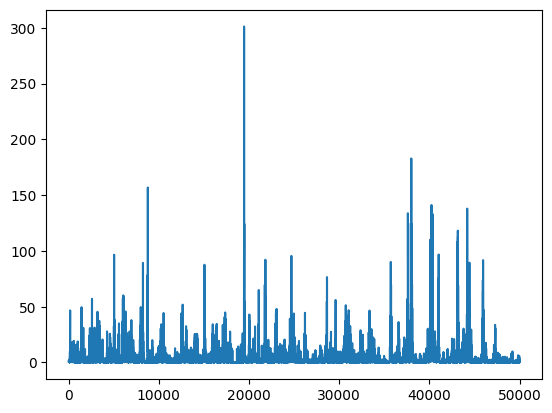

In [25]:
plt.plot((gatlas/g[20])[0])

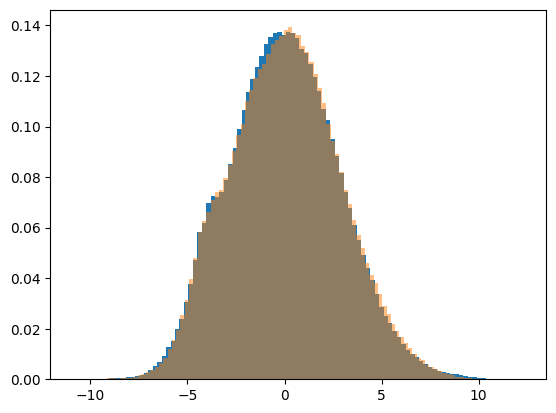

In [439]:
for r in [ 20]:
    plt.hist(s[r][..., 0].flatten(), bins=100, density=True);
# plt.hist(s2[..., 0].flatten(), bins=100, density=True);
# plt.hist(alldata['funnel-11']['nuts'][-1][..., 0].flatten(), bins=100, density=True, alpha=0.5);
plt.hist(alldata[exp]['atlas-logn-unif'][-1][..., 0].flatten(), bins=100, density=True, alpha=0.5);
# plt.hist(ref_samples_funnel[..., 0].flatten(), bins=100, density=True, alpha=0.5, histtype='step', color='k', lw=2);



In [30]:
# s = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank10/samples_constrained-{i}.npy') for i in range(32)])
# g = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank10/gradcounts-{i}.npy') for i in range(32)])
# s2 = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank20/samples_constrained-{i}.npy') for i in range(32)])
# g2 = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank20/gradcounts-{i}.npy') for i in range(32)])
ss = {}
gg = {}
for exp in ['funnel-51', 'multifunnel-100', 'glmm-poisson', 'irt_2pl', 'stochastic_volatility']:
    r = 20
    try:
        ss[exp] = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank{r}-testend/samples_constrained-{i}.npy') for i in range(32)])
        gg[exp] = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank{r}-testend/gradcounts-{i}.npy') for i in range(32)])
    except Exception as e:
        print(e)


In [31]:
for exp in ss:
    print(exp)
    if 'funnel' in exp:
        err = get_rmses(ss[exp], reference_samples[exp])[1]
        print(np.percentile(err[0][..., 0], [10, 50, 90]), np.percentile(err[1][..., 0], [10, 50, 90]))
        err = get_rmses(alldata[exp]['atlas-logn-unif'][-1], reference_samples[exp])[1]
        print(np.percentile(err[0][..., 0], [10, 50, 90]), np.percentile(err[1][..., 0], [10, 50, 90]))
    else:
        err = get_rmses(ss[exp], reference_samples[exp])[0]
        print(np.percentile(err[0], [10, 50, 90]), np.percentile(err[1], [10, 50, 90]))
        err = get_rmses(alldata[exp]['atlas-logn-unif'][-1], reference_samples[exp])[0]
        print(np.percentile(err[0], [10, 50, 90]), np.percentile(err[1], [10, 50, 90]))


print(['Experiment', 'ATLAS (K=20)', 'ATLAS'])
p0, p1 = 20, 80
for exp in ss:
    if 'funnel' in exp:
        err = get_rmses(ss[exp], reference_samples[exp])[1]
        err = [err[0][..., 0], err[1][..., 0]]
        err1 = get_rmses(alldata[exp]['atlas-logn-unif'][-1], reference_samples[exp])[1]
        err1 = [err1[0][..., 0], err1[1][..., 0]]
    else:
        err = get_rmses(ss[exp], reference_samples[exp])[0]
        err1 = get_rmses(alldata[exp]['atlas-logn-unif'][-1], reference_samples[exp])[0]
    
    tp = [exp]        
    v0, vm, v1 = np.percentile(err[0], [p0, 50, p1])
    tp.append(f"{vm:0.3f} ({v0:0.3f}, {v1:0.3f})")
    v0, vm, v1 = np.percentile(err1[0], [p0, 50, p1])
    tp.append(f"{vm:0.3f} ({v0:0.3f}, {v1:0.3f})")
    print(tp)                                   
                               
    tp = [exp + '(sq)']
    v0, vm, v1 = np.percentile(err[1], [p0, 50, p1])
    tp.append(f"{vm:0.3f} ({v0:0.3f}, {v1:0.3f})")
    v0, vm, v1 = np.percentile(err1[1], [p0, 50, p1])
    tp.append(f"{vm:0.3f} ({v0:0.3f}, {v1:0.3f})")
    print(tp)


print(['Experiment', 'ATLAS (K=20)', 'ATLAS'])
for exp in ss:
    print([exp, gg[exp].sum()/alldata[exp]['nuts'][0].sum(), alldata[exp]['atlas-logn-unif'][0].sum()/alldata[exp]['nuts'][0].sum()])


funnel-51
[-0.12684818  0.00703305  0.12093307] [-0.1795489  -0.11346986  0.0400419 ]
[-0.11890419  0.03741287  0.12583134] [-0.12531518 -0.09590064 -0.02171268]
multifunnel-100
[-0.03362045  0.0239331   0.10077658] [-0.07389987 -0.0189935   0.04229081]
[-0.03093604  0.02278603  0.08803116] [-0.05898101 -0.02330695  0.02788939]
glmm-poisson
[0.02044611 0.0234529  0.02792897] [0.03248542 0.03616137 0.04498265]
[0.01947935 0.02202313 0.02624814] [0.03145445 0.03595608 0.04124135]
irt_2pl
[0.02265321 0.02720302 0.04233542] [0.03160065 0.03721941 0.0489871 ]
[0.02221121 0.02669016 0.03220474] [0.03109722 0.03424005 0.03892229]
stochastic_volatility
[0.03137772 0.04237855 0.06791435] [0.03158893 0.04534726 0.07179462]
[0.02988218 0.04687006 0.07366015] [0.03137405 0.0497107  0.08067139]
['Experiment', 'ATLAS (K=20)', 'ATLAS']
['funnel-51', '0.007 (-0.049, 0.088)', '0.037 (-0.085, 0.087)']
['funnel-51(sq)', '-0.113 (-0.150, 0.021)', '-0.096 (-0.121, -0.049)']
['multifunnel-100', '0.024 (-0.0

In [59]:
# alldata['multifunnel-100']['atlas-logn-rank20']

In [60]:

# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:
for exp in ["funnel-51", "multifunnel-100", "glmm-poisson", "irt_2pl", "stochastic_volatility"]:

    print(exp)
    nsamples = alldata[exp]['nuts'][-1].shape[1]
    if 'lotka' in exp: nchains = 30
    else: nchains = 32

    data = {}
    data['ref'] = reference_samples[exp]
    data['nuts' ] = alldata[exp]['nuts']
    
    # ss[exp] = np.array([np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2prop-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank{r}-testend/samples_constrained-{i}.npy') for i in range(32)])
    # suffixes = [ '', '-lognormal-stepsig1.2']
    # keys = ['atlas-hmc-beta', 'atlas-hmc-logn']
    suffixes = [ '-prob1-ctraj2-uninleap-lognormal-stepsig1.2-rank20-testend']
    keys = [ 'atlas-logn-rank20']
    algfolder = 'atlasv2prop-nuts-indep' 
    ik = 0
    for suffix in suffixes: 
        key = f"{keys[ik]}"
        ik += 1
        path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset1.00{suffix}/'
        if check_key(key, exp, nsamples, nchains):
            if exp == 'multifunnel-100' :
                samples = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(16)])[:, :nsamples].astype('float32')
                grads = np.stack([np.load(f'{path}/gradcounts-{i}.npy')[:nsamples] for i in range(16)])[:, :nsamples].astype('float32')
                count = grads[:, :nsamples].sum(axis=1)
                rmses, errs = get_rmses(samples, data['ref'])
                data[key] =  count, rmses, errs, samples

            else: data = get_data(path, key, data, nsamples)
            
    for key in data:
        alldata[exp][key] = data[key]
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

# boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=labels)
# if save : 
#     plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
#     plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
# plt.show()




funnel-51
atlas-logn-rank20 exists for funnel-51
multifunnel-100
incompatible shapes
glmm-poisson
atlas-logn-rank20 exists for glmm-poisson
irt_2pl
atlas-logn-rank20 exists for irt_2pl
stochastic_volatility
atlas-logn-rank20 exists for stochastic_volatility


funnel-51
multifunnel-100


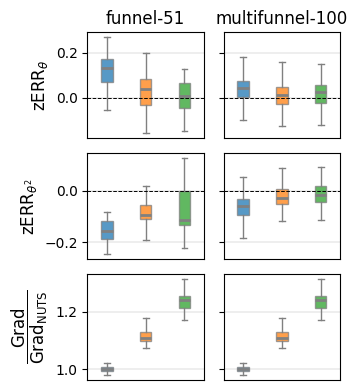

In [75]:
keystoplot = ['nuts', 'atlas-logn-unif', 'atlas-logn-rank20']
lbls = ['NUTS', 'Atlas',  'Atlas (r=20)']
expstoplot = ["funnel-51", "multifunnel-100"]
# expstoplot = ["glmm-poisson", "irt_2pl", "stochastic_volatility"]
nexps   = len(expstoplot)
fliers = False
boxplots = {}   
fig, ax = plt.subplots(3, nexps, figsize=(nexps*1.8, 4), sharex='col', sharey='row')

for n, exp in enumerate(expstoplot):
    print(exp)
    bplots = {}        
    try:
        if 'funnel' in exp:
            data = alldata[exp]
            D = int(exp.split('-')[1])
            errs, errs2, lblkey = [], [], []
            if keystoplot is None: keystoplot = data.keys()
            for key in keystoplot:
                if key == 'ref': continue
                if key not in data.keys(): continue
                errs.append(data[key][2][0])
                errs2.append(data[key][2][1])
                lblkey.append(key)

            if lbls is None: lbls = lblkey
            if 'multifunnel' in exp:
                toplot1 = [[ar[:, :D//10].flatten() for ar in errs], [ar[:, D//10:].flatten() for ar in errs]]
                toplot2 = [[ar[:, :D//10].flatten() for ar in errs2], [ar[:, D//10:].flatten() for ar in errs2]]
                # ax[0, n].set_title(f'{exp}\nlog_sigma', fontsize=fsize)
                # ax[0, i+1].set_title(f'{exp}\nlatents')                
                
            elif 'funnel' in exp:
                toplot1 = [[ar[:, :1].flatten() for ar in errs], [ar[:, 1:].flatten() for ar in errs]]
                toplot2 = [[ar[:, :1].flatten() for ar in errs2], [ar[:, 1:].flatten() for ar in errs2]]

            bplot1 = ax[0, n].boxplot(toplot1[0], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);
            bplot2 = ax[1, n].boxplot(toplot2[0], patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, showfliers=fliers);

        else:
            data = alldata[exp]
            boxerror, boxerror2, boxgrads, lblkeys = get_boxes(data, keystoplot)
            if lbls is None: lbls = lblkeys
                
            bplot1 = ax[0, n].boxplot(boxerror, patch_artist=True,
                        boxprops=dict(alpha=0.7), labels=lbls, meanline=True, showfliers=fliers);
                        # boxprops=dict(facecolor='C0', color='gray', alpha=0.7), labels=lbls, meanline=True, showfliers=fliers);
            bplot2 = ax[1, n].boxplot(boxerror2, patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, meanline=True, showfliers=fliers);

        bplot3 = ax[2, n].boxplot(boxgrads, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.75), labels=lbls, meanline=True, showfliers=fliers);

        boxplots[exp] = [bplot1, bplot2, bplot3]
        set_boxplot_colors([bplot1, bplot2, bplot3])
        ax[0, n].set_title(exp)
        # ax[2, n].set_xticks(ax[2, n].get_xticks(), ax[2, n].get_xticklabels(), rotation=60, ha='right')
        ax[2, n].set_xticks([])

        # if fliers or logscale: 
        #     ax[0, n].set_yscale('log')
        #     ax[1, n].set_yscale('log')
    except :
        PrintException()
for axis in ax.flatten():
    axis.grid(which='both', lw=0.3)

for axis in ax[:-1].flatten():
    axis.axhline(0, color='k', lw=0.7, ls='--')

# ax[0, 0].set_ylabel(r'zRMSE$_\theta$', fontsize=12)
# ax[1, 0].set_ylabel(r'zRMSE$_{\theta^2}$', fontsize=12)
ax[0, 0].set_ylabel(r'zERR$_\theta$', fontsize=12)
ax[1, 0].set_ylabel(r'zERR$_{\theta^2}$', fontsize=12)
ax[2, 0].set_ylabel(r'$\mathrm{\dfrac{Grad}{Grad_{NUTS}}}$', fontsize=12)
plt.tight_layout()

    
for i in range(len(lbls)):
    ax[-1, nexps//2].plot(np.NaN, np.NaN, color=f'C{i}', label=lbls[i], lw=3)
# ax[-1, nexps//2].legend(bbox_to_anchor=(0, -0.1, 1.2, 0), ncol=len(lbls), fontsize=14)
    



In [443]:
# from scipy.optimize import fmin_l_bfgs_b, LbfgsInvHessProduct

# def objective_function(x):
#     # Define your objective function here
#     return x[0]**2 + x[1]**2

# def gradient(x):
#     # Define the gradient of your objective function here
#     return [2 * x[0], 2 * x[1]]

# x0 = np.array([1, 1])  # Initial guess
# x, _, _ = fmin_l_bfgs_b(objective_function, x0, fprime=gradient)

# # Access the inverse Hessian operator
# # inv_hess = LbfgsInvHessProduct(sk=np.array([x]*10), yk=np.array([x]*10))  # Update sk and yk with L-BFGS updates
# inv_hess = LbfgsInvHessProduct(sk=np.random.random((10, 2)), yk=np.random.random((10, 2)))  # Update sk and yk with L-BFGS updates

# # Compute the product of the inverse Hessian with a vector
# vector = [1, 2]
# result = inv_hess.dot(vector)

# print("Inverse Hessian product:", result)

In [181]:
# inv_hess = LbfgsInvHessProduct(sk=np.array([x]*10), yk=np.array([x]*10))  # Update sk and yk with L-BFGS updates
D = 100
inv_hess = LbfgsInvHessProduct(sk=np.random.random((10, D)), yk=np.random.random((10, D)))  # Update sk and yk with L-BFGS updates

# Compute the product of the inverse Hessian with a vector
vector = np.random.random(D)
result = inv_hess.dot(vector)
result

array([ 0.92551744,  0.38931887, -0.58437412,  0.26304942,  0.83259896,
        1.52178842, -0.33082332,  0.87121011,  0.30809256, -0.00961199,
        0.10381844,  1.15264767,  0.89687179,  0.54347222, -0.34459974,
       -0.12137111,  1.20302895,  1.06570463,  0.66494659, -0.09818797,
        1.48382199,  0.06675311,  1.31252815,  1.24804952,  0.76607978,
        0.71702077,  0.13273199, -0.32505673,  0.87582496,  0.00527263,
        0.23215025,  0.62424324, -0.02894172,  0.27691731, -0.40938247,
        0.47612452,  0.82922468,  0.18406051, -0.73114147,  1.68711825,
        1.36964102,  0.66305769,  0.33849421,  1.02911685,  0.58045185,
        0.67723014,  1.73179688,  0.4683309 ,  1.61068797, -0.51895788,
        1.06069513,  0.12903028,  1.34779338,  1.43465438,  1.36728558,
        0.6790603 ,  0.51998876,  0.25017544,  0.47042394,  0.87970523,
        0.71865402,  1.08643888,  0.46096263, -0.04321294,  1.02756529,
        0.29436229,  0.73526273,  1.15077415,  0.06433436,  0.45

In [197]:
D = 1000
inv_hess = LbfgsInvHessProduct(sk=np.random.random((10, D)), yk=np.random.random((10, D)))  # Update sk and yk with L-BFGS updates

# Compute the product of the inverse Hessian with a vector
vector = np.random.random(D)
%timeit result = inv_hess.dot(vector)


75.9 µs ± 231 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [183]:
rank = 2
D = 1000
inv_hess = LbfgsInvHessProduct(sk=np.random.random((rank, D)), yk=np.random.random((rank, D)))  # Update sk and yk with L-BFGS updates

# Compute the product of the inverse Hessian with a vector
vector = np.random.random(D)
%timeit result = inv_hess.dot(vector)


17.9 µs ± 55.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [184]:
rank = 20
D = 1000
inv_hess = LbfgsInvHessProduct(sk=np.random.random((rank, D)), yk=np.random.random((rank, D)))  # Update sk and yk with L-BFGS updates

# Compute the product of the inverse Hessian with a vector
vector = np.random.random(D)
%timeit result = inv_hess.dot(vector)


76 µs ± 565 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [442]:
rank = 20
D = 10000
inv_hess = LbfgsInvHessProduct(sk=np.random.random((rank, D)), yk=np.random.random((rank, D)))  # Update sk and yk with L-BFGS updates

# Compute the product of the inverse Hessian with a vector
vector = np.random.random(D)
%timeit result = inv_hess.dot(vector)


526 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## NUTS 0.95

(<Figure size 1500x280 with 5 Axes>,
 array([<Axes: title={'center': 'funnel-11'}, xlabel='log $\\sigma$'>,
        <Axes: title={'center': 'funnel-51'}, xlabel='log $\\sigma$'>,
        <Axes: title={'center': 'multifunnel-100'}, xlabel='log $\\sigma$'>,
        <Axes: title={'center': 'rosenbrock-2'}, xlabel='first parameter'>,
        <Axes: title={'center': 'rosenbrockhy3-3'}, xlabel='first parameter'>],
       dtype=object))

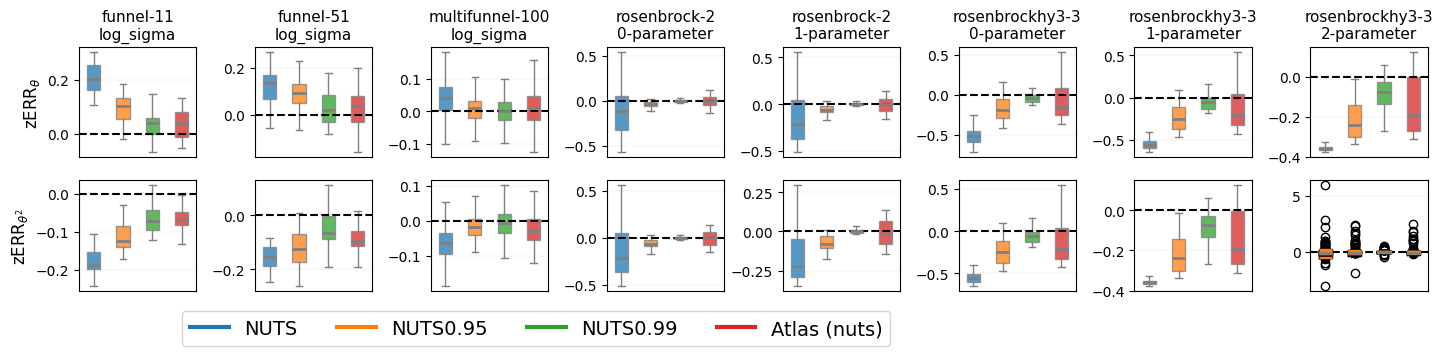

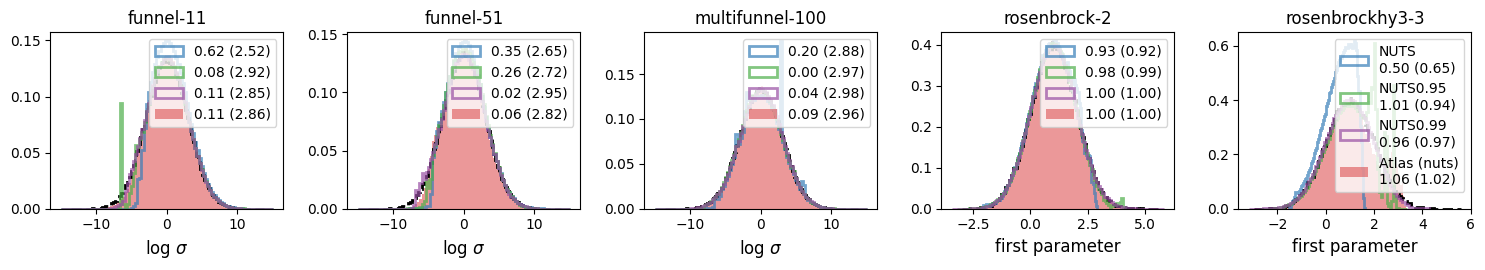

In [545]:
# keystoplot = ['nuts', 'atlas-logn', 'atlas-beta', 'atlas-logn-unif', 'atlas-beta-unif']
# keystoplot = ['nuts', 'atlas-logn',  'atlas-logn-unif']

save = True
save = False
prefix = 'atlas_nuts'

keystoplot = ['nuts', 'nuts0.95', 'nuts0.99', 'atlas-logn-unif', 'atlas-logn-unif-0.65']
labels = ['NUTS', 'NUTS-0.95', 'NUTS-0.99', 'Atlas (nuts)',  'Atlas (0.6)']#,  'Atlas (0.65)']
keystoplot = ['nuts', 'nuts0.95', 'nuts0.99', 'atlas-logn-unif']
labels = ['NUTS', 'NUTS0.95',  'NUTS0.99',  'Atlas (nuts)']

# boxplot_experiments(alldata, sharex='col', sharey='row', baselines=None, keystoplot=keystoplot, lbls=labels)
# if save : 
#     plt.savefig(f'./figs/{prefix}_allexp.png', bbox_inches='tight')
#     plt.savefig(f'./figs/{prefix}_allexp.pdf', bbox_inches='tight')
# plt.show()

_ = boxplot_funnel_rosenbrock(alldata, sharex='col', sharey=False, keystoplot=keystoplot, fliers=False, lbls=labels);

histogram_funnel_rosenbrock(alldata, keystoplot=keystoplot, lbls=labels)



In [529]:
for exp in alldata:
    # try: print(exp, alldata[exp]['atlas-logn-unif'][-1].shape)
    try: print(exp, alldata[exp]['nuts0.99'][-1].shape)
    except : print(exp)

rosenbrock-2 (32, 49999, 2)
funnel-11 (32, 49999, 11)
funnel-51 (32, 49999, 51)
multifunnel-100 (32, 49999, 100)
rosenbrockhy3-3 (32, 49999, 3)
corr_normal95-100
ill_normal-100
hmm
lotka_volterra
arK
glmm-poisson
irt_2pl
stochastic_volatility


In [530]:
for exp in alldata:
    g0 = alldata[exp]['nuts'][0].sum()
    try:
        cost = [alldata[exp][alg][0].sum()/g0 for alg in ['nuts0.95', 'nuts0.99', 'atlas-logn-unif']]
        print(exp, cost)
    except : 
        cost = [alldata[exp][alg][0].sum()/g0 for alg in ['nuts0.95', 'atlas-logn-unif']]
        print(exp, cost)

rosenbrock-2 [4.7849565, 9.369849, 4.8485456]
funnel-11 [1.8675375, 4.197813, 8.112531]
funnel-51 [1.6767229, 2.6115324, 1.8236922]
multifunnel-100 [1.8263822, 3.922279, 2.3352284]
rosenbrockhy3-3 [8.3975, 29.611055, 17.489931]
corr_normal95-100 [0.7236063, 0.96249765]
ill_normal-100 [0.6572714, 1.2025461]
hmm [0.75048524, 1.8211577]
lotka_volterra [1.523598, 1.7560688]
arK [0.82545185, 1.6114081]
glmm-poisson [1.396221, 1.3516374]
irt_2pl [0.68777645, 1.1782192]
stochastic_volatility [0.8479212, 1.1115694]


In [555]:
gdict = {}
qdict = {}
# q2dict = {}
p0, p1 = 20, 80

for iexp, exp in enumerate(['rosenbrock-2', 'rosenbrockhy3-3', 'funnel-11', 'funnel-51', 'multifunnel-100']):

    ref = reference_samples[exp]
    gs = {}
    ss = {}
    snuts = alldata[exp]['nuts'][-1].copy()
    gnuts = alldata[exp]['nuts'][0].copy()
    err  = get_rmses(snuts, ref)[1]
    ss['nuts'] =  [np.percentile(err[0][:, 0], [p0, 50, p1]),  np.percentile(err[1][:, 0], [p0, 50, p1])] 
    gs['nuts'] = gnuts.sum()/gnuts.sum()
    
    snuts95 = alldata[exp]['nuts0.95'][-1].copy()
    gnuts95 = alldata[exp]['nuts0.95'][0].copy()
    err  = get_rmses(snuts95, ref)[1]
    ss['nuts95'] =  [np.percentile(err[0][:, 0], [p0, 50, p1]),  np.percentile(err[1][:, 0], [p0, 50, p1])] 
    gs['nuts95'] = gnuts95.sum()/gnuts.sum()
    
    # gs['nuts95'] = gatlas.sum()/gnuts.sum()
    snuts99 = alldata[exp]['nuts0.99'][-1].copy()
    gnuts99 = alldata[exp]['nuts0.99'][0].copy()
    err  = get_rmses(snuts99, ref)[1]
    ss['nuts99'] =  [np.percentile(err[0][:, 0], [p0, 50, p1]),  np.percentile(err[1][:, 0], [p0, 50, p1])] 
    gs['nuts99'] = gnuts99.sum()/gnuts.sum()
    
    satlas = alldata[exp]['atlas-logn-unif'][-1].copy()
    gatlas = alldata[exp]['atlas-logn-unif'][0].copy()
    err  = get_rmses(satlas, ref)[1]
    ss['atlas'] =  [np.percentile(err[0][:, 0], [p0, 50, p1]),  np.percentile(err[1][:, 0], [p0, 50, p1])] 
    gs['atlas'] = gatlas.sum()/gnuts.sum()
        
    gdict[exp] = gs.copy()
    qdict[exp ]= ss.copy()


for iexp, exp in enumerate(['rosenbrock-2', 'rosenbrockhy3-3']):

    ref = reference_samples[exp]
    gs = {}
    ss = {}
    snuts = alldata[exp]['nuts'][-1].copy()
    gnuts = alldata[exp]['nuts'][0].copy()
    err  = get_rmses(snuts, ref)[1]
    ss['nuts'] =  [np.percentile(err[0][:, 1], [p0, 50, p1]),  np.percentile(err[1][:, 1], [p0, 50, p1])] 
    gs['nuts'] = gnuts.sum()/gnuts.sum()
    
    snuts95 = alldata[exp]['nuts0.95'][-1].copy()
    gnuts95 = alldata[exp]['nuts0.95'][0].copy()
    err  = get_rmses(snuts95, ref)[1]
    ss['nuts95'] =  [np.percentile(err[0][:, 1], [p0, 50, p1]),  np.percentile(err[1][:, 1], [p0, 50, p1])] 
    gs['nuts95'] = gnuts95.sum()/gnuts.sum()
    
    # gs['nuts95'] = gatlas.sum()/gnuts.sum()
    snuts99 = alldata[exp]['nuts0.99'][-1].copy()
    gnuts99 = alldata[exp]['nuts0.99'][0].copy()
    err  = get_rmses(snuts99, ref)[1]
    ss['nuts99'] =  [np.percentile(err[0][:, 1], [p0, 50, p1]),  np.percentile(err[1][:, 1], [p0, 50, p1])] 
    gs['nuts99'] = gnuts99.sum()/gnuts.sum()
    
    satlas = alldata[exp]['atlas-logn-unif'][-1].copy()
    gatlas = alldata[exp]['atlas-logn-unif'][0].copy()
    err  = get_rmses(satlas, ref)[1]
    ss['atlas'] =  [np.percentile(err[0][:, 1], [p0, 50, p1]),  np.percentile(err[1][:, 1], [p0, 50, p1])] 
    gs['atlas'] = gatlas.sum()/gnuts.sum()
        
    gdict[exp + '(1)'] = gs.copy()
    qdict[exp + '(1)' ]= ss.copy()

In [557]:
print(['Algorithm', 'NUTS', 'NUTS (0.95)', 'NUTS (0.99)', 'Atlas'])
print()
for key in gdict:
    tp = [key]
    for k in gdict[key]:
        # tp.append(f"({qdict[key][k][0]}), {gdict[key][k]:0.2f}")
        tp.append(f"{gdict[key][k]:0.2f}")
        # tp.append()
    print(tp)


print()
for key in qdict:
    if 'multifunnel' in key: continue
    tp = [key]
    for k in qdict[key]:
        tp.append(f"{qdict[key][k][0][1]:0.2f} ({qdict[key][k][0][0]:0.2f}, {qdict[key][k][0][2]:0.2f})")
    print(tp)
    tp = [key + '(sq)']
    for k in qdict[key]:
        tp.append(f"{qdict[key][k][1][1]:0.2f} ({qdict[key][k][1][0]:0.2f}, {qdict[key][k][1][2]:0.2f})")
    print(tp)
    
# print()
# for key in qdict:
#     tp = [key + r'$(\theta^2)$)']
#     for k in qdict[key]:
#         tp.append(f"{qdict[key][k][1][1]:0.2f} ({qdict[key][k][1][0]:0.2f}, {qdict[key][k][1][2]:0.2f})")
#     print(tp)

['Algorithm', 'NUTS', 'NUTS (0.95)', 'NUTS (0.99)', 'Atlas']

['rosenbrock-2', '1.00', '4.78', '9.37', '4.85']
['rosenbrockhy3-3', '1.00', '8.40', '29.61', '17.49']
['funnel-11', '1.00', '1.87', '4.20', '8.11']
['funnel-51', '1.00', '1.68', '2.61', '1.82']
['multifunnel-100', '1.00', '1.83', '3.92', '2.34']
['rosenbrock-2(1)', '1.00', '4.78', '9.37', '4.85']
['rosenbrockhy3-3(1)', '1.00', '8.40', '29.61', '17.49']

['rosenbrock-2', '-0.11 (-0.35, 0.14)', '-0.04 (-0.07, -0.01)', '-0.00 (-0.02, 0.01)', '0.00 (-0.07, 0.06)']
['rosenbrock-2(sq)', '-0.22 (-0.37, 0.08)', '-0.06 (-0.09, -0.01)', '-0.00 (-0.01, 0.01)', '-0.00 (-0.07, 0.06)']
['rosenbrockhy3-3', '-0.52 (-0.61, -0.43)', '-0.19 (-0.32, 0.09)', '-0.04 (-0.09, 0.02)', '-0.15 (-0.27, 0.25)']
['rosenbrockhy3-3(sq)', '-0.56 (-0.60, -0.50)', '-0.25 (-0.39, 0.01)', '-0.05 (-0.14, 0.01)', '-0.21 (-0.34, 0.25)']
['funnel-11', '0.20 (0.16, 0.26)', '0.10 (0.04, 0.13)', '0.04 (-0.01, 0.07)', '0.04 (-0.02, 0.08)']
['funnel-11(sq)', '-0.19 (-0

In [547]:
qdict['funnel-11']

{'nuts': [array([-0.00449818,  0.00024934,  0.00635764]),
  array([-0.00923187, -0.00205872,  0.00598538])],
 'nuts95': [array([-0.00372219,  0.00120897,  0.00724434]),
  array([-0.01033858, -0.00482228,  0.00657845])],
 'nuts99': [array([-0.00466574,  0.00037618,  0.00626513]),
  array([-0.01480638, -0.00978378, -0.00134836])],
 'atlas': [array([-0.01517357,  0.04160522,  0.08394489]),
  array([-0.08660144, -0.06908466, -0.04276441])]}

In [559]:
az.rhat(alldata['funnel-11']['nuts'][-1][...,0])

1.0089759383092136

In [562]:
az.rhat(alldata['rosenbrockhy3-3']['nuts'][-1][...,0])

1.0638618164911466

## stepsigma = 0.2

In [123]:
gdict = {}
qdict = {}
# q2dict = {}
p0, p1 = 20, 80

for iexp, exp in enumerate(alldata.keys()):

    if 'funnel' in exp or 'rosenbrock' in exp or 'normal' in exp: continue

    ref = reference_samples[exp]
    gs = {}
    ss = {}
    keystoplot = ['nuts',  'atlas-logn-unif', 'nuts-s1.10x', 'atlas-logn-unif-s1.10x', 'atlas-logn-unif-s1.20x', 'atlas-logn-unif-s1.50x', 'atlas-logn-unif-s2.00x']
    labels = ['NUTS', 'Atlas',  'NUTS 1.1x', 'Atlas 1.1x', 'Atlas 1.2x', 'Atlas 1.5x', 'Atlas 2.0x']
    gnuts = alldata[exp]['nuts'][0].copy()
    
    for ik, k in enumerate(keystoplot):
        s = alldata[exp][k][-1].copy()
        g = alldata[exp][k][0].copy()
        err  = get_rmses(s, ref)[0]
        ss[labels[ik]] =  [np.percentile(err[0], [p0, 50, p1]),  np.percentile(err[1], [p0, 50, p1])] 
        gs[labels[ik]] = g.sum()/gnuts.sum()
        
    gdict[exp] = gs.copy()
    qdict[exp ]= ss.copy()



In [124]:
print(['Algorithm'] + labels)
print()
for key in gdict:
    tp = [key]
    for k in gdict[key]:
        # tp.append(f"({qdict[key][k][0]}), {gdict[key][k]:0.2f}")
        tp.append(f"{gdict[key][k]:0.2f}")
        # tp.append()
    print(tp)


print()
for key in qdict:
    if 'multifunnel' in key: continue
    tp = [key]
    # for k in qdict[key]:
    #     tp.append(f"{qdict[key][k][0][1]:0.2f} ({qdict[key][k][0][0]:0.2f}, {qdict[key][k][0][2]:0.2f})")
    # print(tp)
    tp = [key ]
    for k in qdict[key]:
        tp.append(f"{qdict[key][k][1][1]:0.2f} ({qdict[key][k][1][0]:0.2f}, {qdict[key][k][1][2]:0.2f})")
    print(tp)
    


['Algorithm', 'NUTS', 'Atlas', 'NUTS 1.1x', 'Atlas 1.1x', 'Atlas 1.2x', 'Atlas 1.5x', 'Atlas 2.0x']

['hmm', '1.00', '1.82', '0.79', '1.78', '1.62', '2.34', '3.72']
['lotka_volterra', '1.00', '1.76', '0.32', '1.75', '1.84', '2.35', '3.53']
['arK', '1.00', '1.61', '0.88', '1.59', '1.60', '2.08', '3.71']
['glmm-poisson', '1.00', '1.35', '0.56', '1.28', '1.23', '1.14', '1.41']
['irt_2pl', '1.00', '1.18', '0.28', '1.19', '1.21', '1.26', '1.72']
['stochastic_volatility', '1.00', '1.11', '0.57', '1.08', '1.06', '1.06', '1.50']

['hmm', '0.02 (0.02, 0.03)', '0.04 (0.03, 0.05)', '0.13 (0.04, 0.84)', '0.04 (0.03, 0.06)', '0.05 (0.03, 0.06)', '0.05 (0.04, 0.06)', '0.03 (0.02, 0.04)']
['lotka_volterra', '0.03 (0.02, 0.05)', '0.03 (0.02, 0.04)', '6638.97 (3.40, 32892.94)', '0.03 (0.03, 0.05)', '0.04 (0.03, 0.06)', '0.06 (0.05, 0.09)', '0.04 (0.03, 0.06)']
['arK', '0.03 (0.02, 0.03)', '0.04 (0.03, 0.05)', '3.54 (0.58, 9.06)', '0.04 (0.03, 0.06)', '0.04 (0.03, 0.05)', '0.06 (0.05, 0.07)', '0.03 (0.0

In [76]:
exp = 'glmm-poisson'
s = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80/samples.npy')[:, :2001]
sd = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80-diag/samples.npy') 
g = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80/leapfrogs.npy')[:, :2001]
gd = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80-diag/leapfrogs.npy') 

In [90]:
g.sum()/ gd.sum()

16.980259344517496

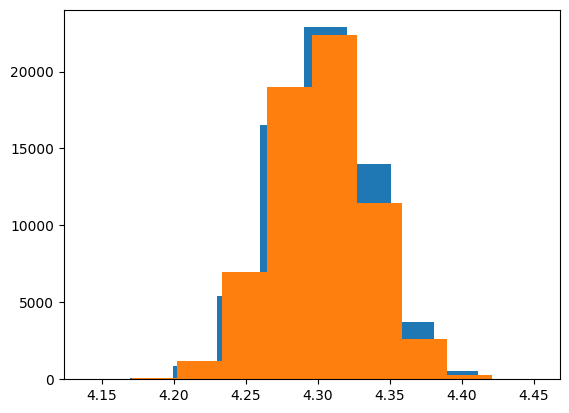

In [78]:
plt.hist(s[:, :2000][..., 0].flatten())
plt.hist(sd[..., 0].flatten());


(0.0, 20.0)

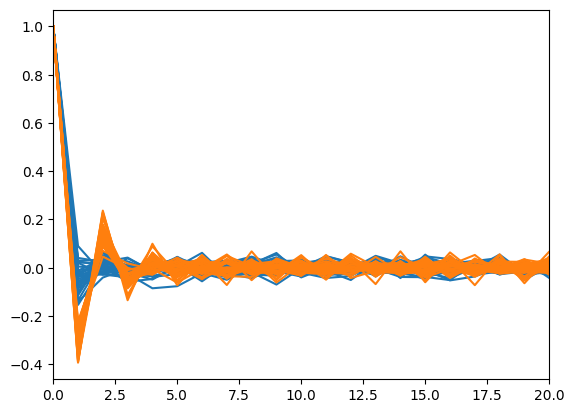

In [88]:
i = 6 
for j in range(32):
    plt.plot(az.autocorr(s[j, :, i]), 'C0')
for j in range(32):
    plt.plot(az.autocorr(sd[j, :, i]), 'C1')
plt.xlim(0, 20)

In [80]:
for i in range(s.shape[-1]):
    print(i, az.ess(s[..., i])/az.ess(sd[..., i]))

0 1.0490572687059558
1 1.1684229612299557
2 1.0046132436581086
3 1.199297611632172
4 0.93344540804505
5 0.5934065029391096
6 0.5906026544408961
7 0.5701751895069883
8 0.5859312756537147
9 0.5530427059279546
10 0.5446270719851297
11 0.574490267363367
12 0.5870015300612296
13 0.5706405807340524
14 0.57439552744862
15 0.5575296913731673
16 0.5992625675269329
17 0.6040995474230438
18 0.6116110013086837
19 0.6298966811041643
20 0.6551905006138725
21 0.6272906903578663
22 0.6753760444558025
23 0.6807856584725412
24 0.6833944105307048
25 0.7279867457985454
26 0.7147068096325487
27 0.7836629251825636
28 0.7135240790586831
29 0.778035795332753
30 0.8049858851897614
31 0.8472538888839861
32 0.8177932554433693
33 0.8272215236204016
34 0.8654057027720701
35 0.9441158185779013
36 0.8897312403800249
37 0.9732683301168938
38 0.949371332577611
39 0.9257797766421846
40 0.9435746302317524
41 0.8875834363639836
42 0.8350065338998138
43 0.8791837393124895
44 0.8903686741625133


In [35]:
from scipy.stats import lognorm

(array([999.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00000000e-01, 3.00339865e+16, 6.00679730e+16, 9.01019596e+16,
        1.20135946e+17, 1.50169933e+17, 1.80203919e+17, 2.10237906e+17,
        2.40271892e+17, 2.70305879e+17, 3.00339865e+17]),
 <BarContainer object of 10 artists>)

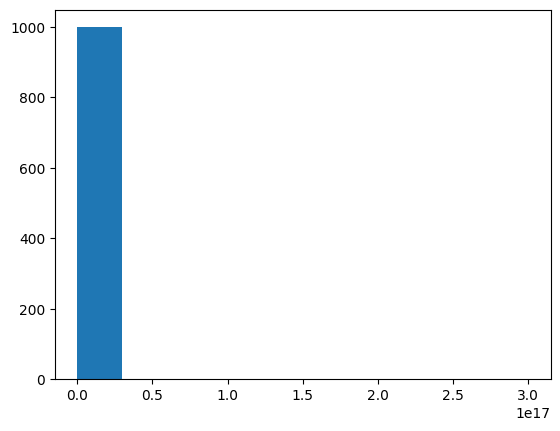

In [56]:
plt.hist(lognorm((10, ), loc=0.1).rvs(1000))


(0.0, 1.0)

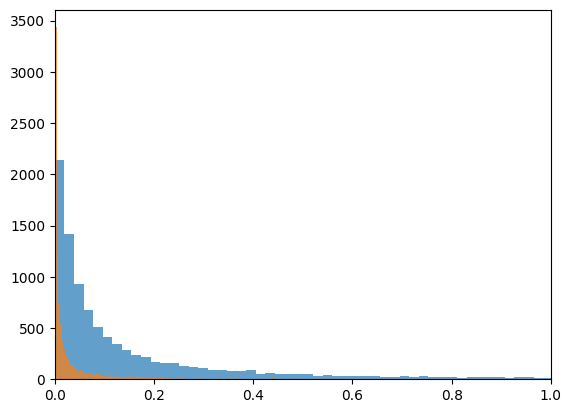

In [74]:
# Target mean and standard deviation of the lognormal distribution
num_samples = 10000

mean_lognormal = 0.3
std_dev_lognormal = 1.2
mu = np.log((mean_lognormal**2) / np.sqrt(std_dev_lognormal**2 + mean_lognormal**2))
sigma = np.sqrt(np.log((std_dev_lognormal**2 / mean_lognormal**2) + 1))
samples = np.random.lognormal(mean=mu, sigma=sigma, size=num_samples)
plt.hist(samples, alpha=0.7, bins='auto');

mean_lognormal = 0.1
std_dev_lognormal = 1.2
mu = np.log((mean_lognormal**2) / np.sqrt(std_dev_lognormal**2 + mean_lognormal**2))
sigma = np.sqrt(np.log((std_dev_lognormal**2 / mean_lognormal**2) + 1))
samples = np.random.lognormal(mean=mu, sigma=sigma, size=num_samples)
plt.hist(samples, alpha=0.7, bins='auto');
plt.xlim(0, 1)

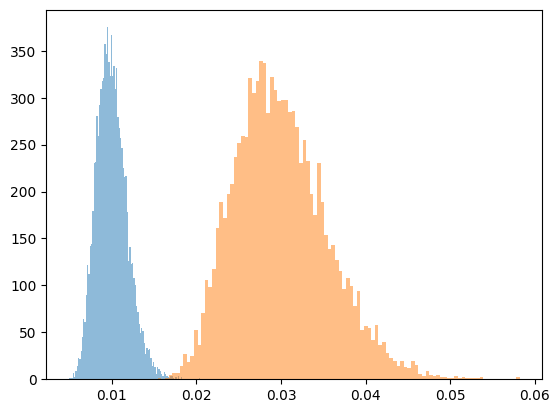

In [79]:
from scipy.stats import norm

class Lognormal_distribution():

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.logsigma = np.log(sigma)
        self.offset = self.logsigma**2/2
        self.logmu = np.log(self.mu) - self.offset
        self.normal_dist = norm(loc=self.logmu,  scale=self.logsigma)

    def rvs(self, size):
        y = self.normal_dist.rvs(size)
        x = np.exp(y)
        return x


plt.hist(Lognormal_distribution(0.01, 1.2).rvs(10000), alpha=0.5, bins=100);
plt.hist(Lognormal_distribution(0.03, 1.2).rvs(10000), alpha=0.5, bins=100);

In [87]:
mu = 0.13
Lognormal_distribution(mu, 1.2).rvs(10000).mean(), Lognormal_distribution(mu, 1.2).rvs(10000).std()

(0.12970474854568423, 0.024212053128902695)

In [91]:
np.exp(log(Lognormal_distribution(mu, 1.2).rvs(10000)).std())


1.200966727056579